In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.4"

import utils
from chemtrain import quantity
import pickle as pkl
import dataset

import numpy as np
from order_parameters import plot_helicity_gyration
import importlib

# Rg vs Qhel

In [2]:
CA_indices_ref = [8,18,28,38,48,58,68,78,88,98,108,118,128,138,148]
path = '/home/franz/Lala15_ttot=500ns_dt=0.5fs.npz'
data = np.load(path, allow_pickle=True)
data = dict(data)
Coords_ref_raw = data['R']

Ref_coords_CA_500ns = Coords_ref_raw[:, CA_indices_ref, :]
Ref_coords_CA_500ns.shape

Ala15_Dataset = dataset.Ala15_Dataset(train_ratio=0.9, val_ratio=0.1, tott='500ns')
Ala15_Dataset.coarse_grain('CA')
cg_coords = np.concatenate([Ala15_Dataset.cg_dataset_U['training']['R'],Ala15_Dataset.cg_dataset_U['validation']['R'],Ala15_Dataset.cg_dataset_U['testing']['R']], axis=0)

Loading Ala15 dataset from: /home/franz/Lala15_ttot=500ns_dt=0.5fs.npz
Original positions: 0.0 to 8.277000427246094
Scale dataset by 1 for R and 1 for U.
Original positions: 0.0 to 8.277000427246094
Scale dataset by 1 for R and 1 for U.
Original positions: 0.02800000086426735 to 8.27500057220459
Scale dataset by 1 for R and 1 for U.
Training set size: 450000
Validation set size: 50000
Original positions: 0.0 to 8.277000427246094
Scale dataset by 1 for R and 1 for U.
Original positions: 0.0 to 8.277000427246094
Scale dataset by 1 for R and 1 for U.
Original positions: 4.026000499725342 to 8.270000457763672
Scale dataset by 1 for R and 1 for U.


In [3]:
atom_pairs = [(i, i + 1) for i in range(0, 15 - 1)]
CA_means = []
stds = []
# Compute distances for each pair
for pair in atom_pairs:
    distances = utils.compute_atom_distance(cg_coords, pair[0], pair[1], Ala15_Dataset.displacement_fn_U)
    CA_mean_distance = np.mean(distances)
    std_distance = np.std(distances)
    CA_means.append(CA_mean_distance)
    stds.append(std_distance)
    print(f"CA Ref pair {pair}: Mean = {CA_mean_distance:.3f}, Std = {std_distance:.3f}")

ala15_CA_distance_filter = utils.setup_distance_filter_fn(CA_means, Ala15_Dataset.displacement_fn_U, delta=0.05)
line_locs = utils.get_line_locations(t_eq=0, t_tot=5000, n_chains=100, print_every=0.5)

CA Ref pair (0, 1): Mean = 0.386, Std = 0.006
CA Ref pair (1, 2): Mean = 0.386, Std = 0.006
CA Ref pair (2, 3): Mean = 0.386, Std = 0.006
CA Ref pair (3, 4): Mean = 0.386, Std = 0.006
CA Ref pair (4, 5): Mean = 0.386, Std = 0.006
CA Ref pair (5, 6): Mean = 0.386, Std = 0.006
CA Ref pair (6, 7): Mean = 0.386, Std = 0.006
CA Ref pair (7, 8): Mean = 0.386, Std = 0.006
CA Ref pair (8, 9): Mean = 0.386, Std = 0.006
CA Ref pair (9, 10): Mean = 0.386, Std = 0.006
CA Ref pair (10, 11): Mean = 0.386, Std = 0.006
CA Ref pair (11, 12): Mean = 0.386, Std = 0.006
CA Ref pair (12, 13): Mean = 0.386, Std = 0.006
CA Ref pair (13, 14): Mean = 0.386, Std = 0.006


### CA-Map1

Loaded trajectory shape: (1000000, 15, 3)
Input shape: (100, 10000, 15, 3)
>> Processed shape: (100, 10000, 15, 3)
>> Valid frames per chain ns 177.6 ± 343.9
Merged traj shape after filtering: (1000000, 15, 3)
Input coords shape: (1000000, 15, 3)
Valid coords shape: (35520, 15, 3), Number of valid frames: 35520
Frame with max helicity: 160006, value: 0.7693347334861755
Frame with min helicity: 511563, value: 0.0004716030089184642
Frame with max Rg: 821038, value: 2.363614797592163
Frame with min Rg: 70042, value: 0.47942864894866943
Frame with lowest rg + helicity: 60018, value: 0.6931154727935791 (Rg: 0.5678614974021912, Helicity: 0.12525400519371033)


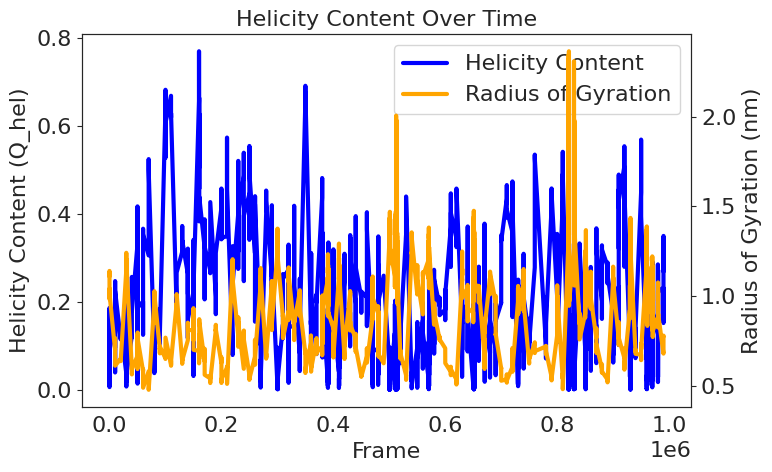

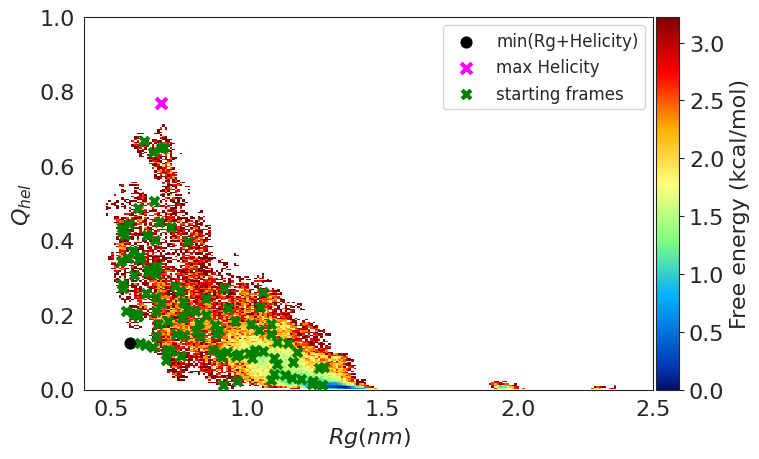

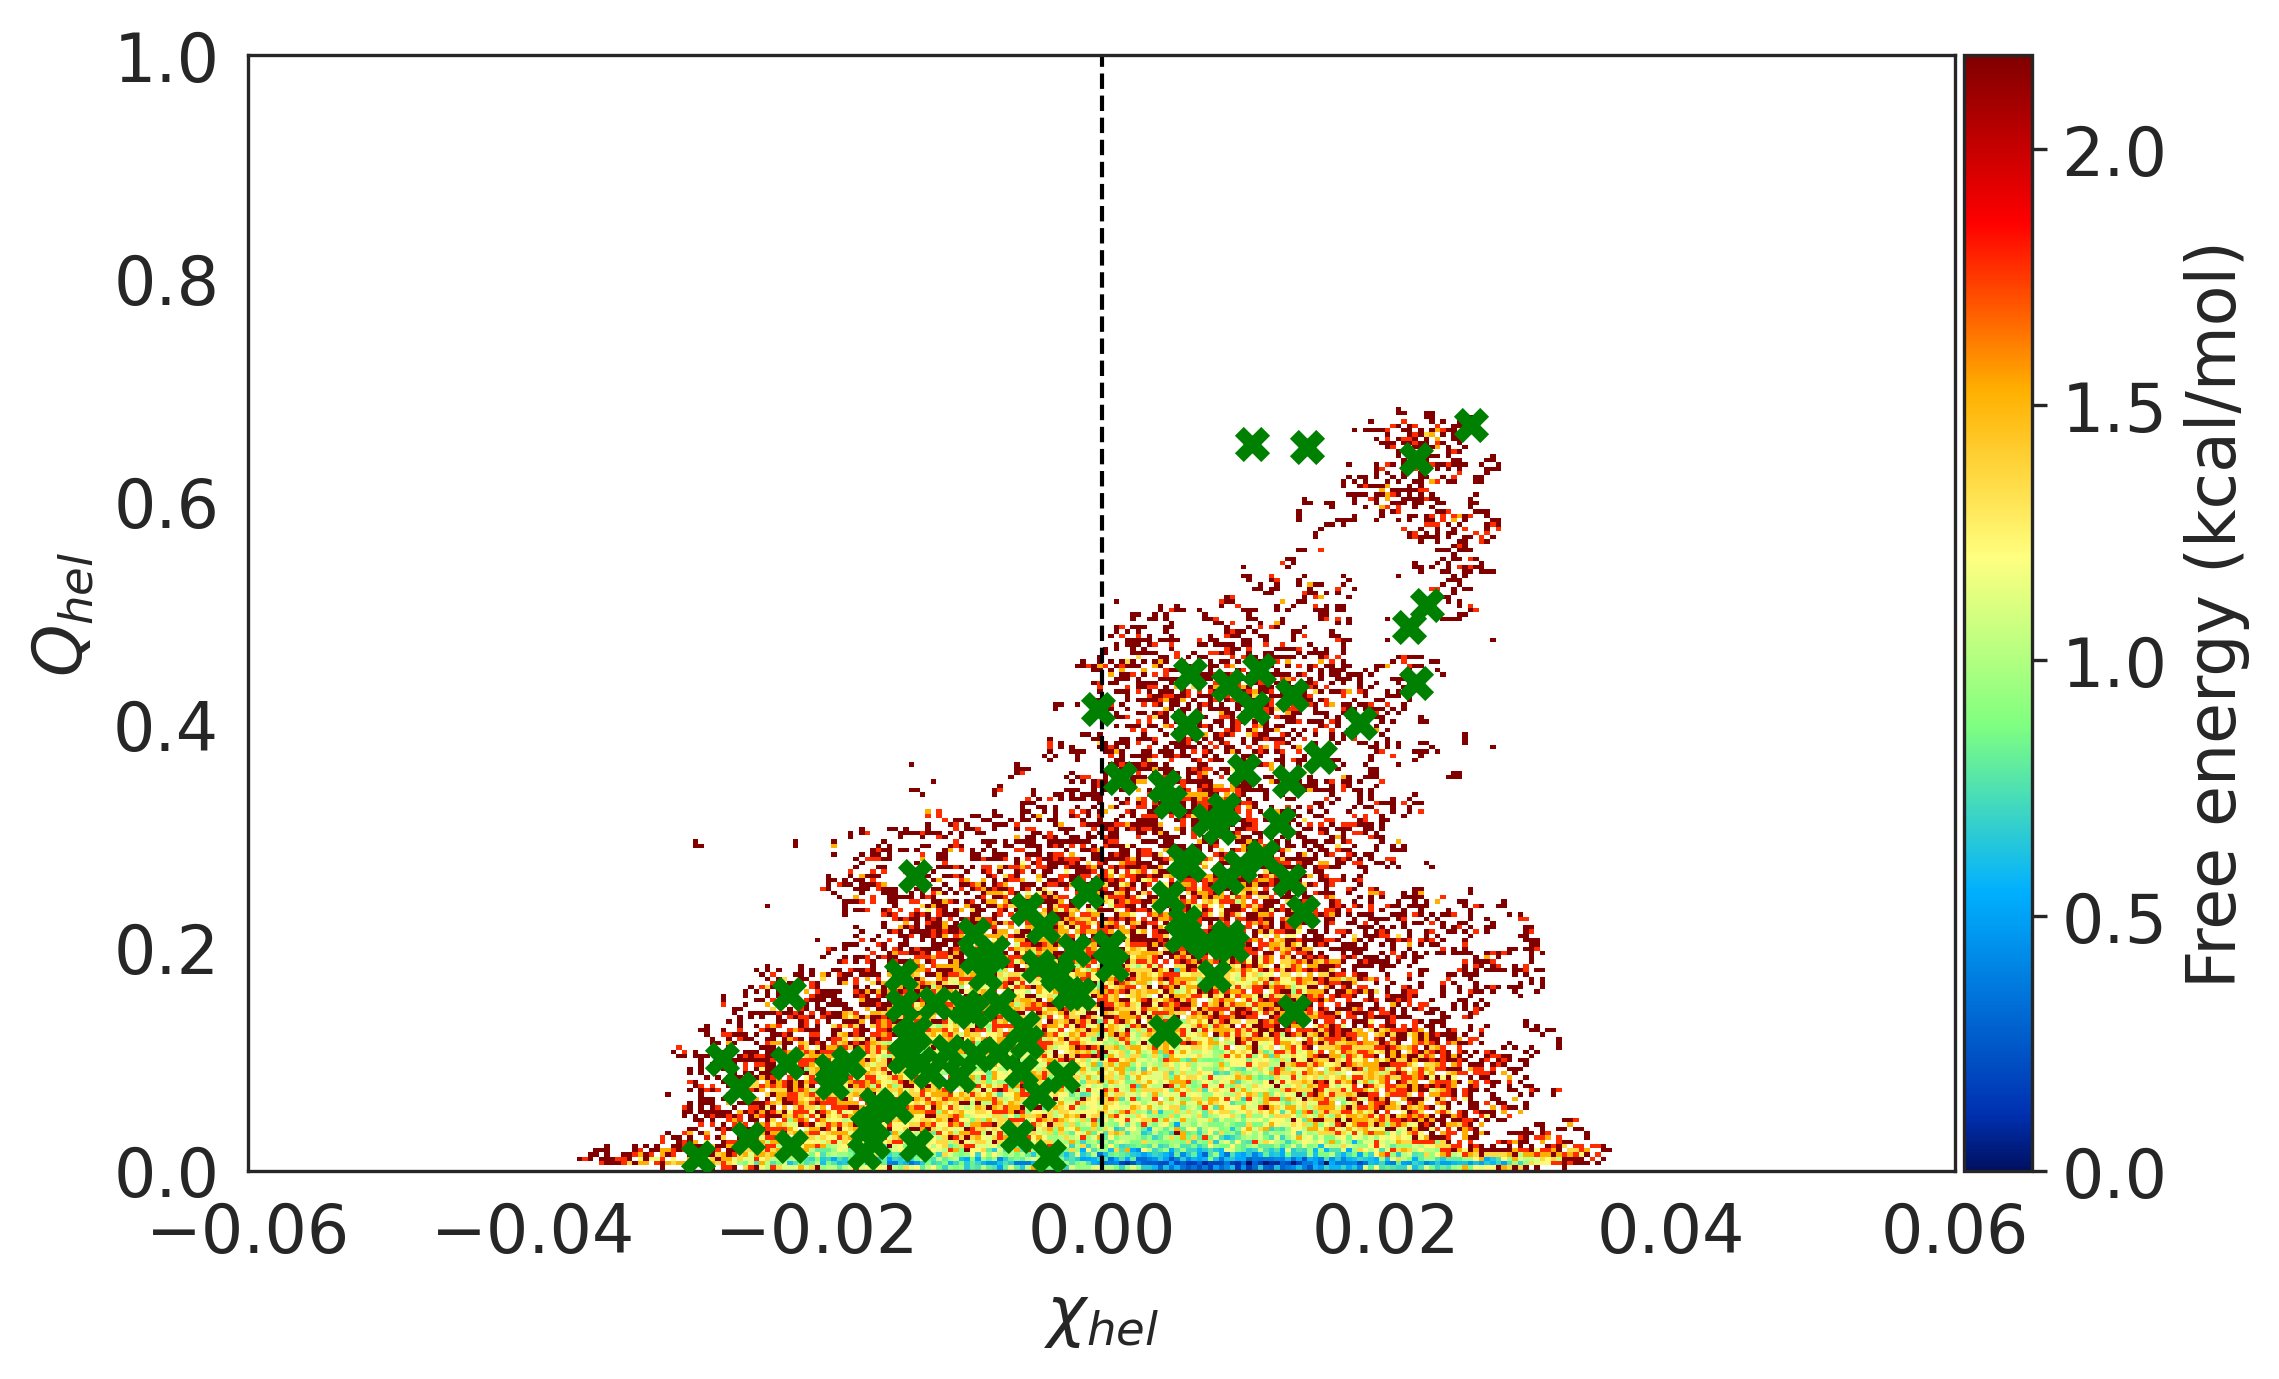

In [6]:
p = 'Ala15/Ala15_map=CA/simulation_NVT/traj_mol=ala15_dt=2_teq=0_t=5000_nmol=1_nchains=100_mode=helix_seed=22/trajectory.pkl'
traj_ = pkl.load(open(p,'rb'))
print('Loaded trajectory shape:', traj_.shape)
starting_frames = [10000*i for i in range(100)]

CA_indices = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
CA_pairs = [(i, i + 1) for i in range(len(CA_indices) - 1)]
traj_CA = traj_[:,CA_indices,:]
traj_starting_frames = traj_CA[starting_frames,:,:]


traj_CA = utils.split_into_chains(traj_CA, line_locs)
traj_CA, mask = ala15_CA_distance_filter(traj_CA, CA_pairs)

# merge chains 
traj_CA_merged = traj_CA.reshape(-1, traj_CA.shape[2], traj_CA.shape[3])
print('Merged traj shape after filtering:', traj_CA_merged.shape)

max_idx, min_idx, min_sum_idx, rg_values_CAMap1, helicity_values_CAMap1, xi_norm_ref_CAMap1 = plot_helicity_gyration(traj_CA_merged,Ala15_Dataset.displacement_fn_U, traj_starting_frames)

### CA-Map2

Loaded trajectory shape: (1000000, 15, 3)
Input shape: (100, 10000, 15, 3)
>> Processed shape: (100, 10000, 15, 3)
>> Valid frames per chain ns 1107.9 ± 1171.4
Merged traj shape after filtering: (1000000, 15, 3)
Input coords shape: (1000000, 15, 3)
Valid coords shape: (221572, 15, 3), Number of valid frames: 221572
Frame with max helicity: 160628, value: 0.855014979839325
Frame with min helicity: 830050, value: 0.0006708053406327963
Frame with max Rg: 830088, value: 2.360531806945801
Frame with min Rg: 482655, value: 0.40403616428375244
Frame with lowest rg + helicity: 450013, value: 0.6722284555435181 (Rg: 0.5801665186882019, Helicity: 0.09206196665763855)


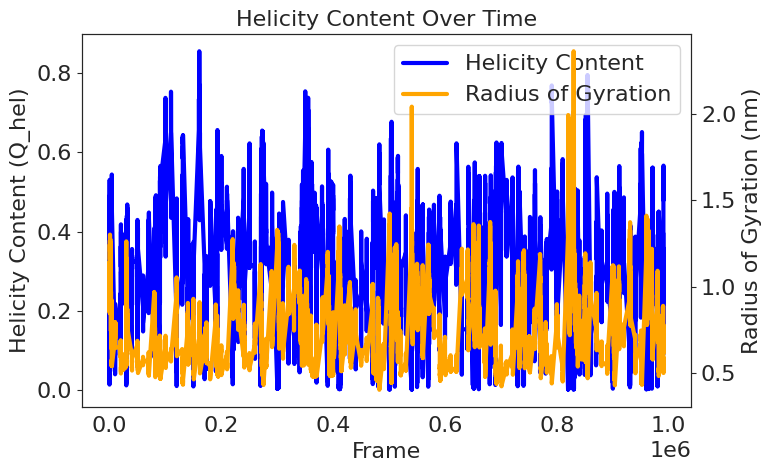

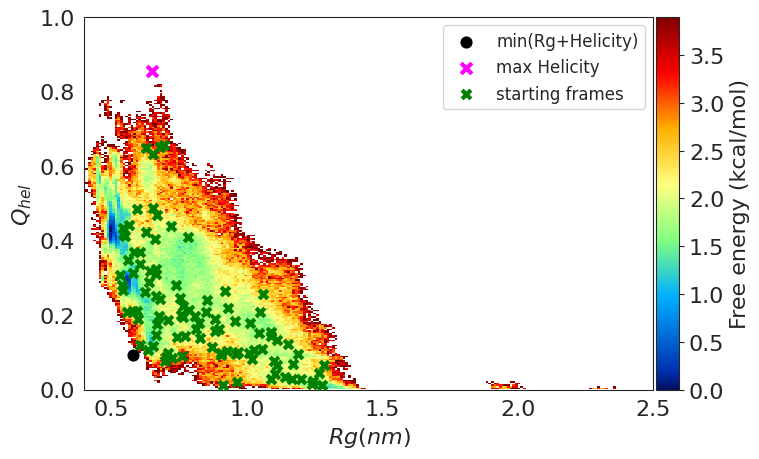

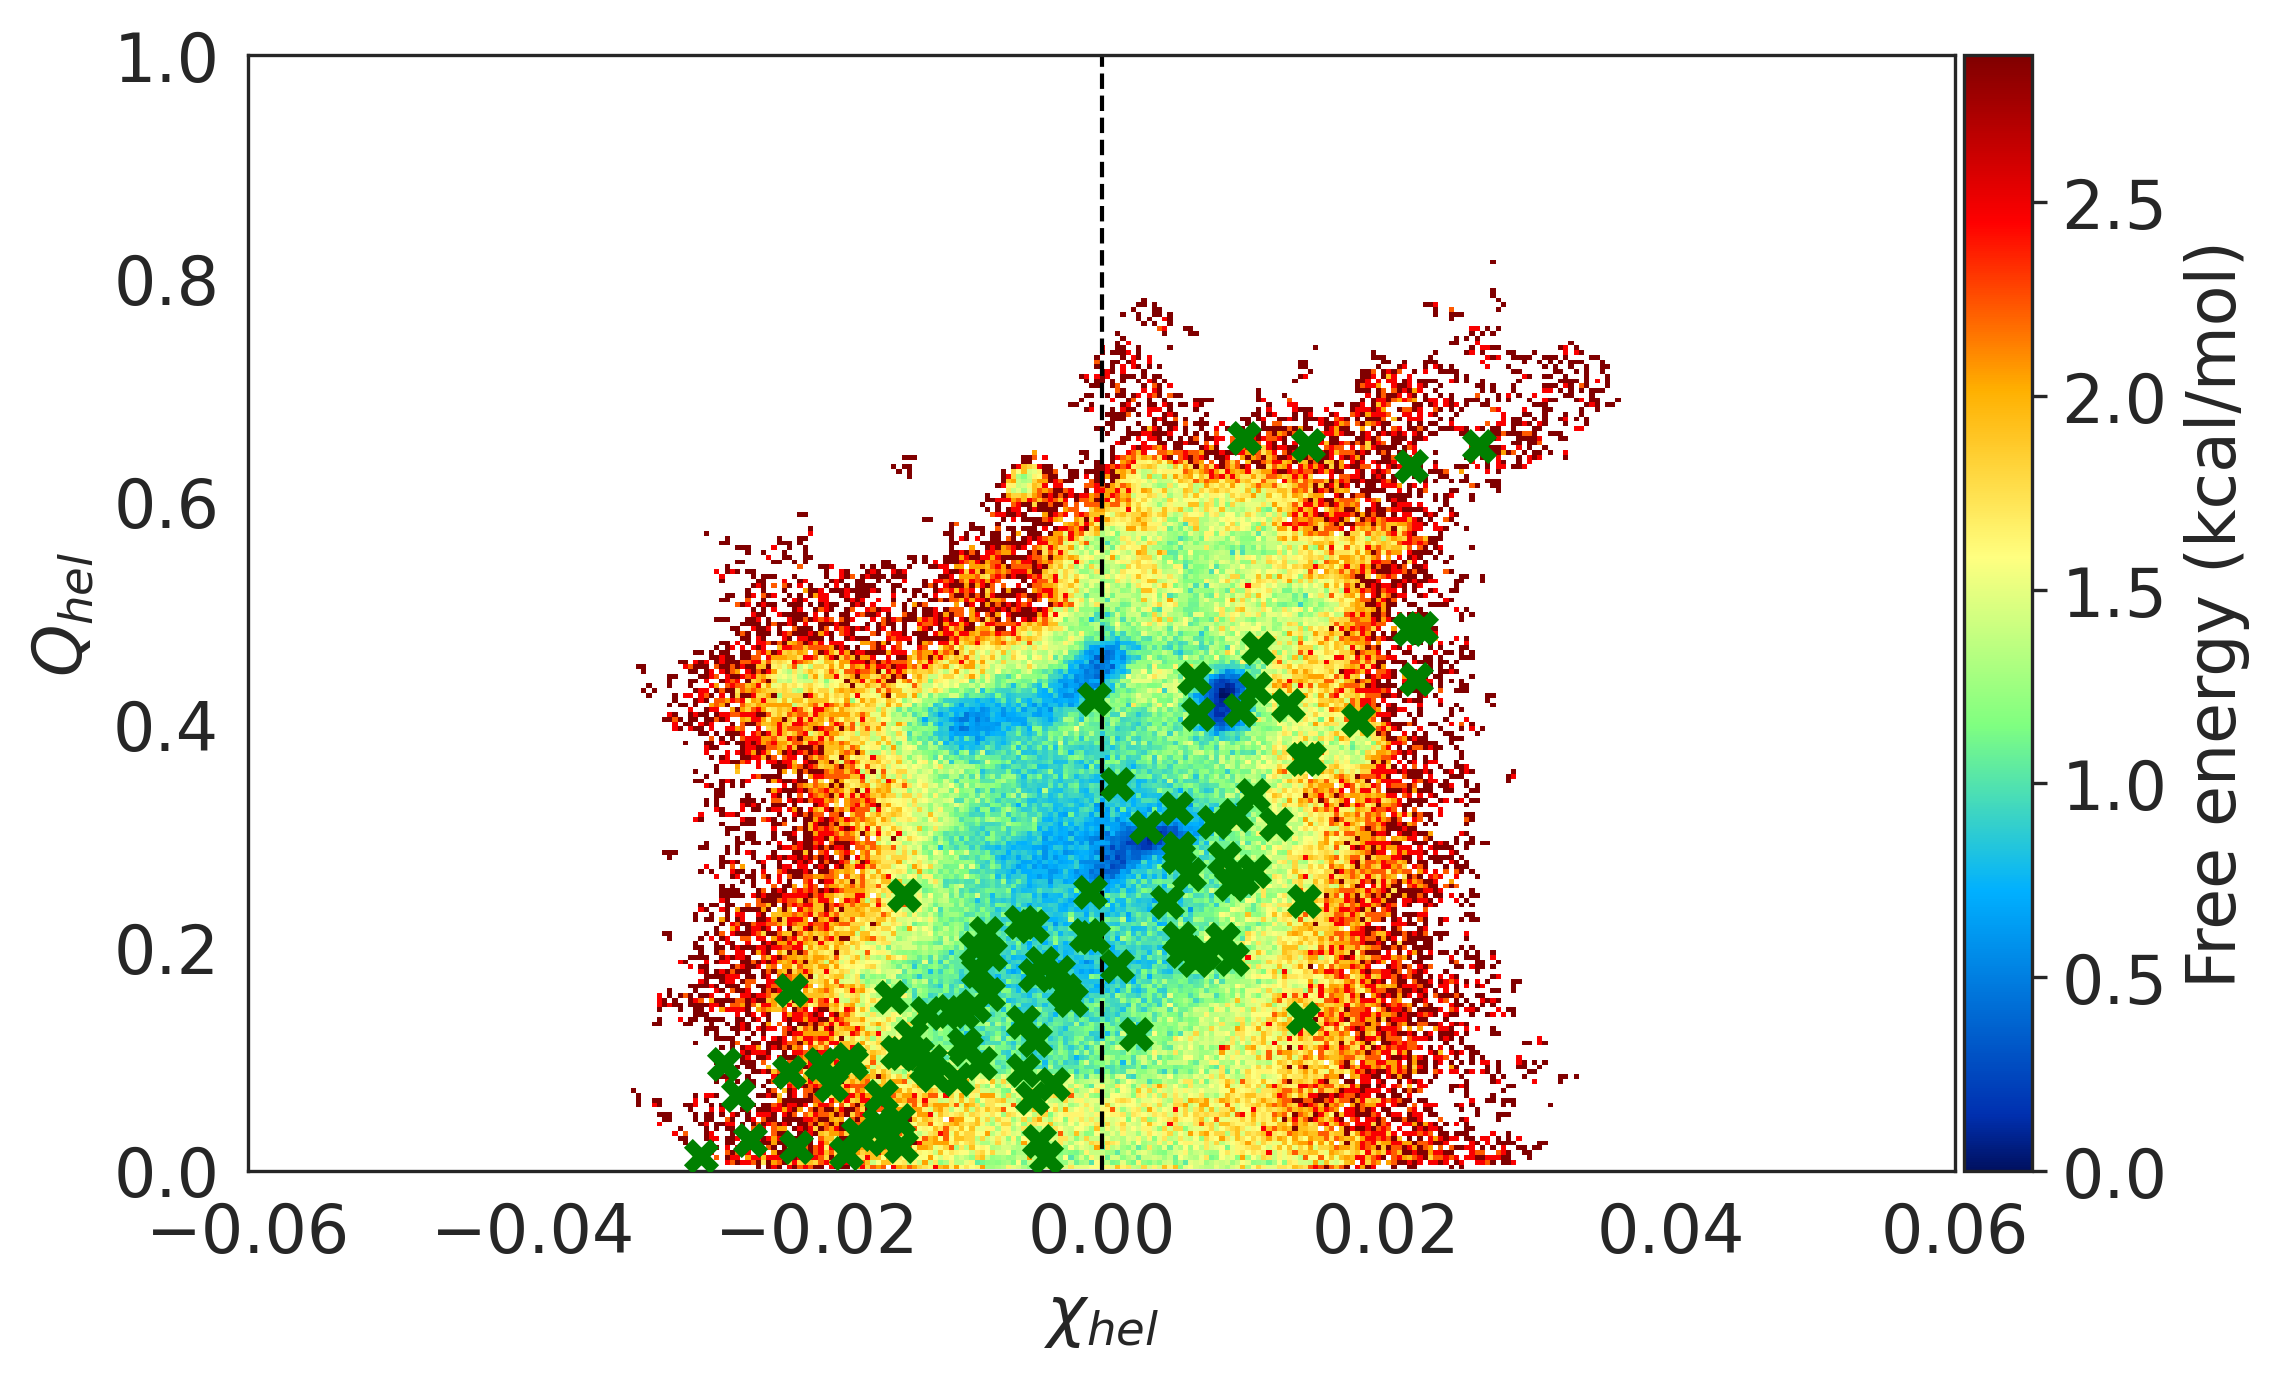

In [7]:
p = 'Ala15/Ala15_map=CA-Map2/simulation_NVT/traj_mol=ala15_dt=2_teq=0_t=5000_nmol=1_nchains=100_mode=helix_seed=22/trajectory.pkl'
traj_ = pkl.load(open(p,'rb'))
print('Loaded trajectory shape:', traj_.shape)
starting_frames = [10000*i for i in range(100)]

CA_indices = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
CA_pairs = [(i, i + 1) for i in range(len(CA_indices) - 1)]
traj_CA = traj_[:,CA_indices,:]
traj_starting_frames = traj_CA[starting_frames,:,:]

traj_CA = utils.split_into_chains(traj_CA, line_locs)
traj_CA, mask = ala15_CA_distance_filter(traj_CA, CA_pairs)

# merge chains 
traj_CA_merged = traj_CA.reshape(-1, traj_CA.shape[2], traj_CA.shape[3])
print('Merged traj shape after filtering:', traj_CA_merged.shape)

max_idx, min_idx, min_sum_idx, rg_values_CAMap2, helicity_values_CAMap2, xi_norm_ref_CAMap2 = plot_helicity_gyration(traj_CA_merged,Ala15_Dataset.displacement_fn_U, traj_starting_frames)

### CA-Map3

Loaded trajectory shape: (1000000, 15, 3)
Input shape: (100, 10000, 15, 3)
>> Processed shape: (100, 10000, 15, 3)
>> Valid frames per chain ns 1048.1 ± 1093.4
Merged traj shape after filtering: (1000000, 15, 3)
Input coords shape: (1000000, 15, 3)
Valid coords shape: (209618, 15, 3), Number of valid frames: 209618
Frame with max helicity: 160006, value: 0.7586864233016968
Frame with min helicity: 501441, value: 0.0006403764709830284
Frame with max Rg: 830088, value: 2.339294910430908
Frame with min Rg: 957899, value: 0.4448702931404114
Frame with lowest rg + helicity: 40056, value: 0.6584479212760925 (Rg: 0.6135465502738953, Helicity: 0.044901397079229355)


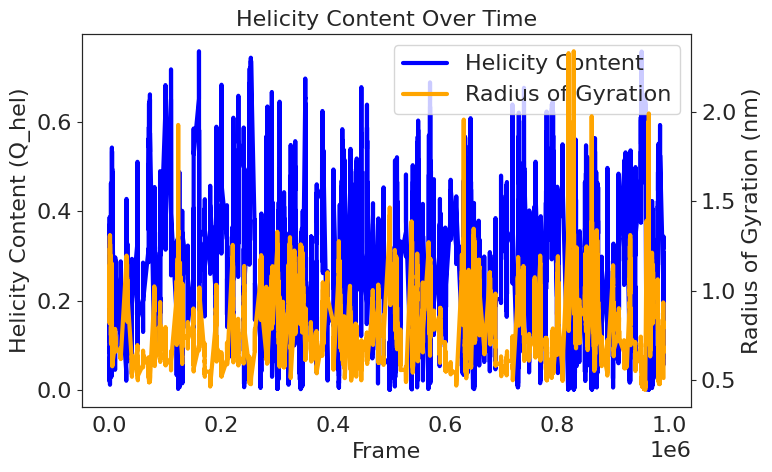

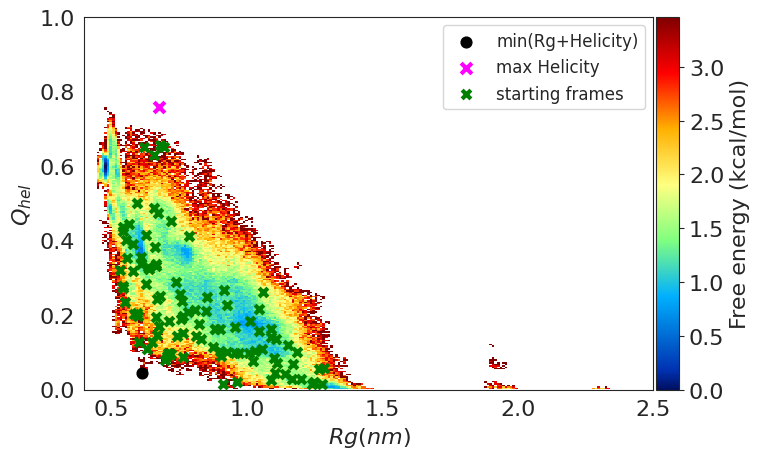

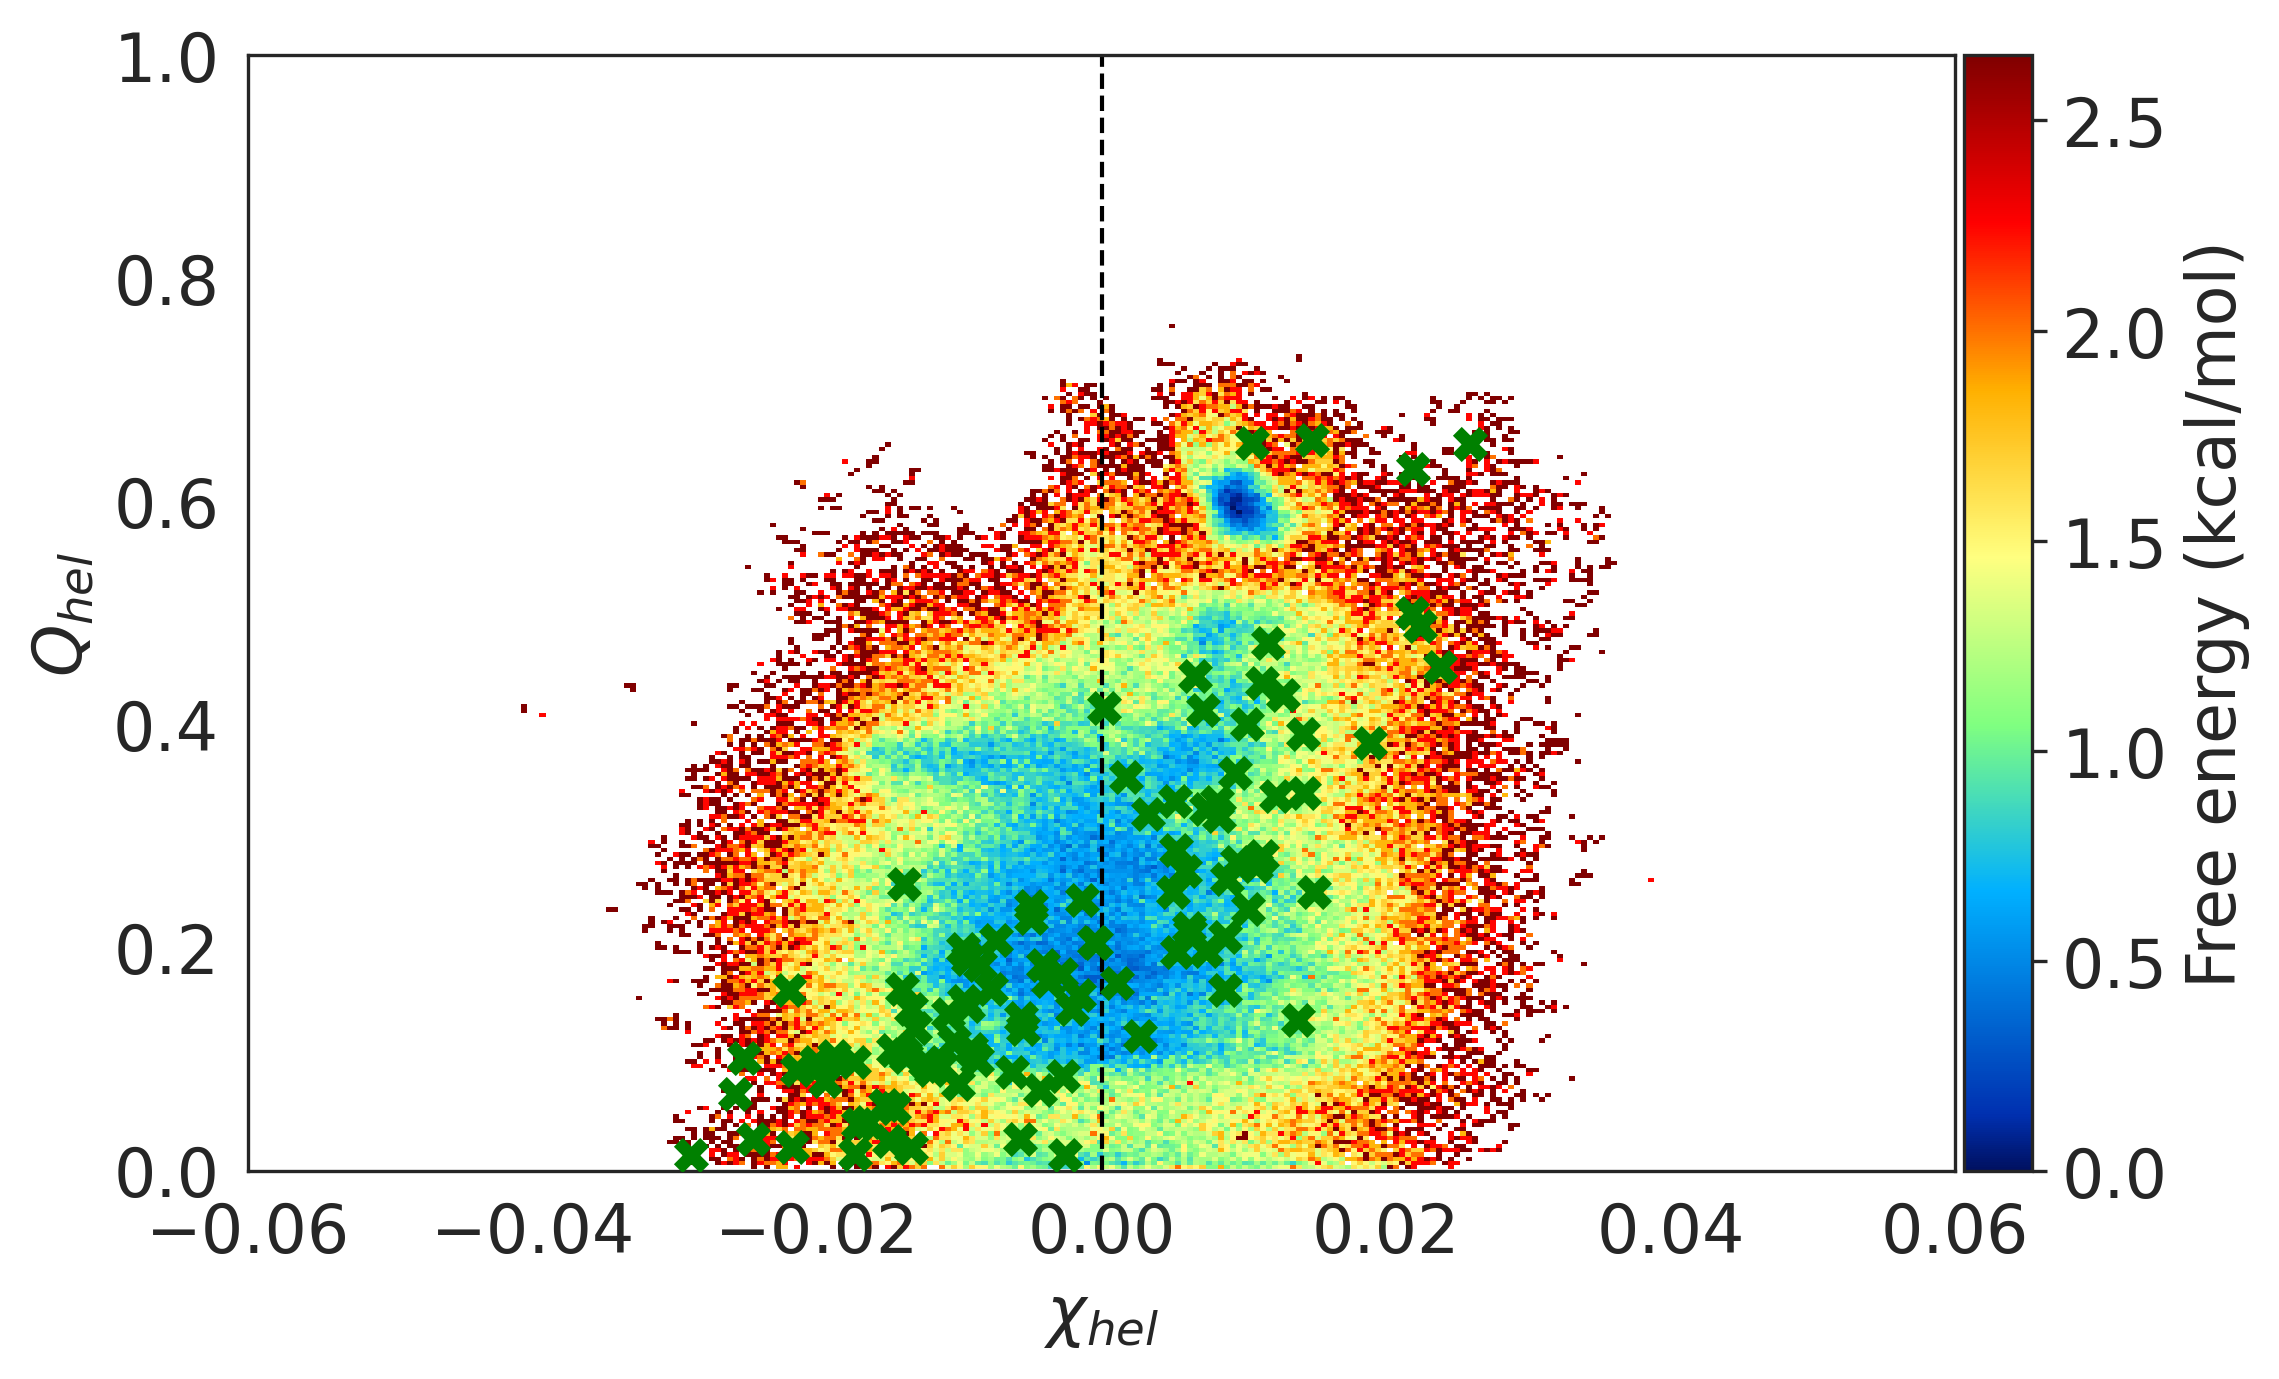

In [8]:
p = 'Ala15/Ala15_map=CA-Map3/simulation_NVT/traj_mol=ala15_dt=2_teq=0_t=5000_nmol=1_nchains=100_mode=helix_seed=22/trajectory.pkl'

traj_ = pkl.load(open(p,'rb'))
print('Loaded trajectory shape:', traj_.shape)
starting_frames = [10000*i for i in range(100)]

CA_indices = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
CA_pairs = [(i, i + 1) for i in range(len(CA_indices) - 1)]
traj_CA = traj_[:,CA_indices,:]
traj_starting_frames = traj_CA[starting_frames,:,:]

traj_CA = utils.split_into_chains(traj_CA, line_locs)
traj_CA, mask = ala15_CA_distance_filter(traj_CA, CA_pairs)

# merge chains 
traj_CA_merged = traj_CA.reshape(-1, traj_CA.shape[2], traj_CA.shape[3])
print('Merged traj shape after filtering:', traj_CA_merged.shape)

max_idx, min_idx, min_sum_idx, rg_values_CAMap3, helicity_values_CAMap3, xi_norm_ref_CAMap3 = plot_helicity_gyration(traj_CA_merged,Ala15_Dataset.displacement_fn_U, traj_starting_frames)

### CA-Map4

Loaded trajectory shape: (1000000, 15, 3)
Input shape: (100, 10000, 15, 3)
>> Processed shape: (100, 10000, 15, 3)
>> Valid frames per chain ns 84.1 ± 127.7
Merged traj shape after filtering: (1000000, 15, 3)
Input coords shape: (1000000, 15, 3)
Valid coords shape: (16825, 15, 3), Number of valid frames: 16825
Frame with max helicity: 160003, value: 0.761450469493866
Frame with min helicity: 820629, value: 0.0005159382708370686
Frame with max Rg: 821019, value: 2.3486249446868896
Frame with min Rg: 620014, value: 0.5063214302062988
Frame with lowest rg + helicity: 40005, value: 0.6799492835998535 (Rg: 0.5864987969398499, Helicity: 0.09345045685768127)


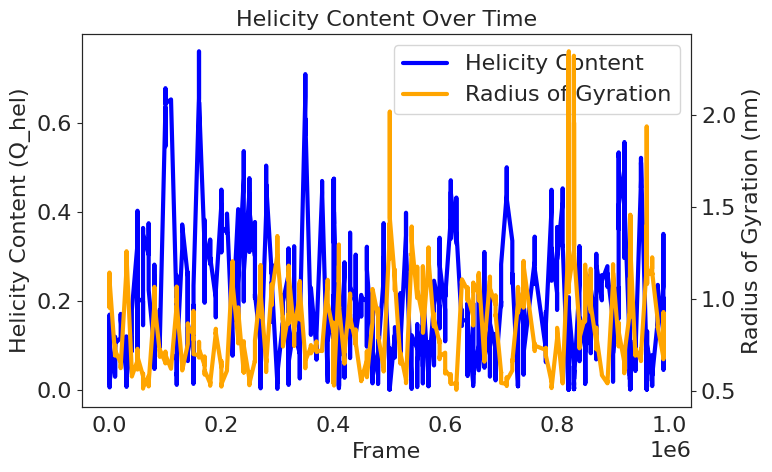

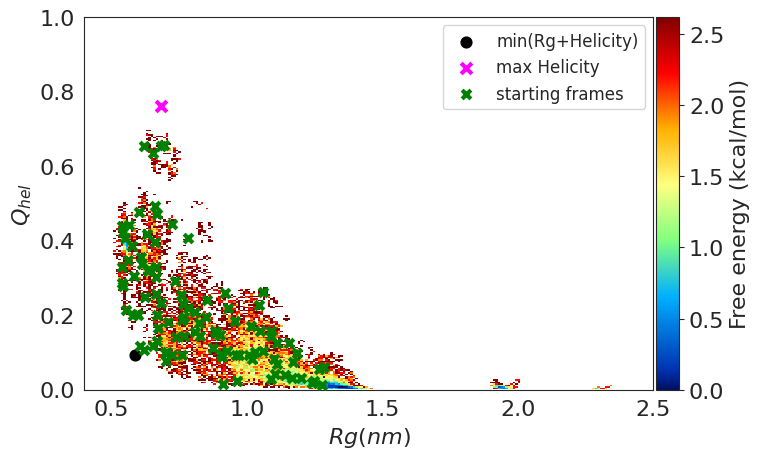

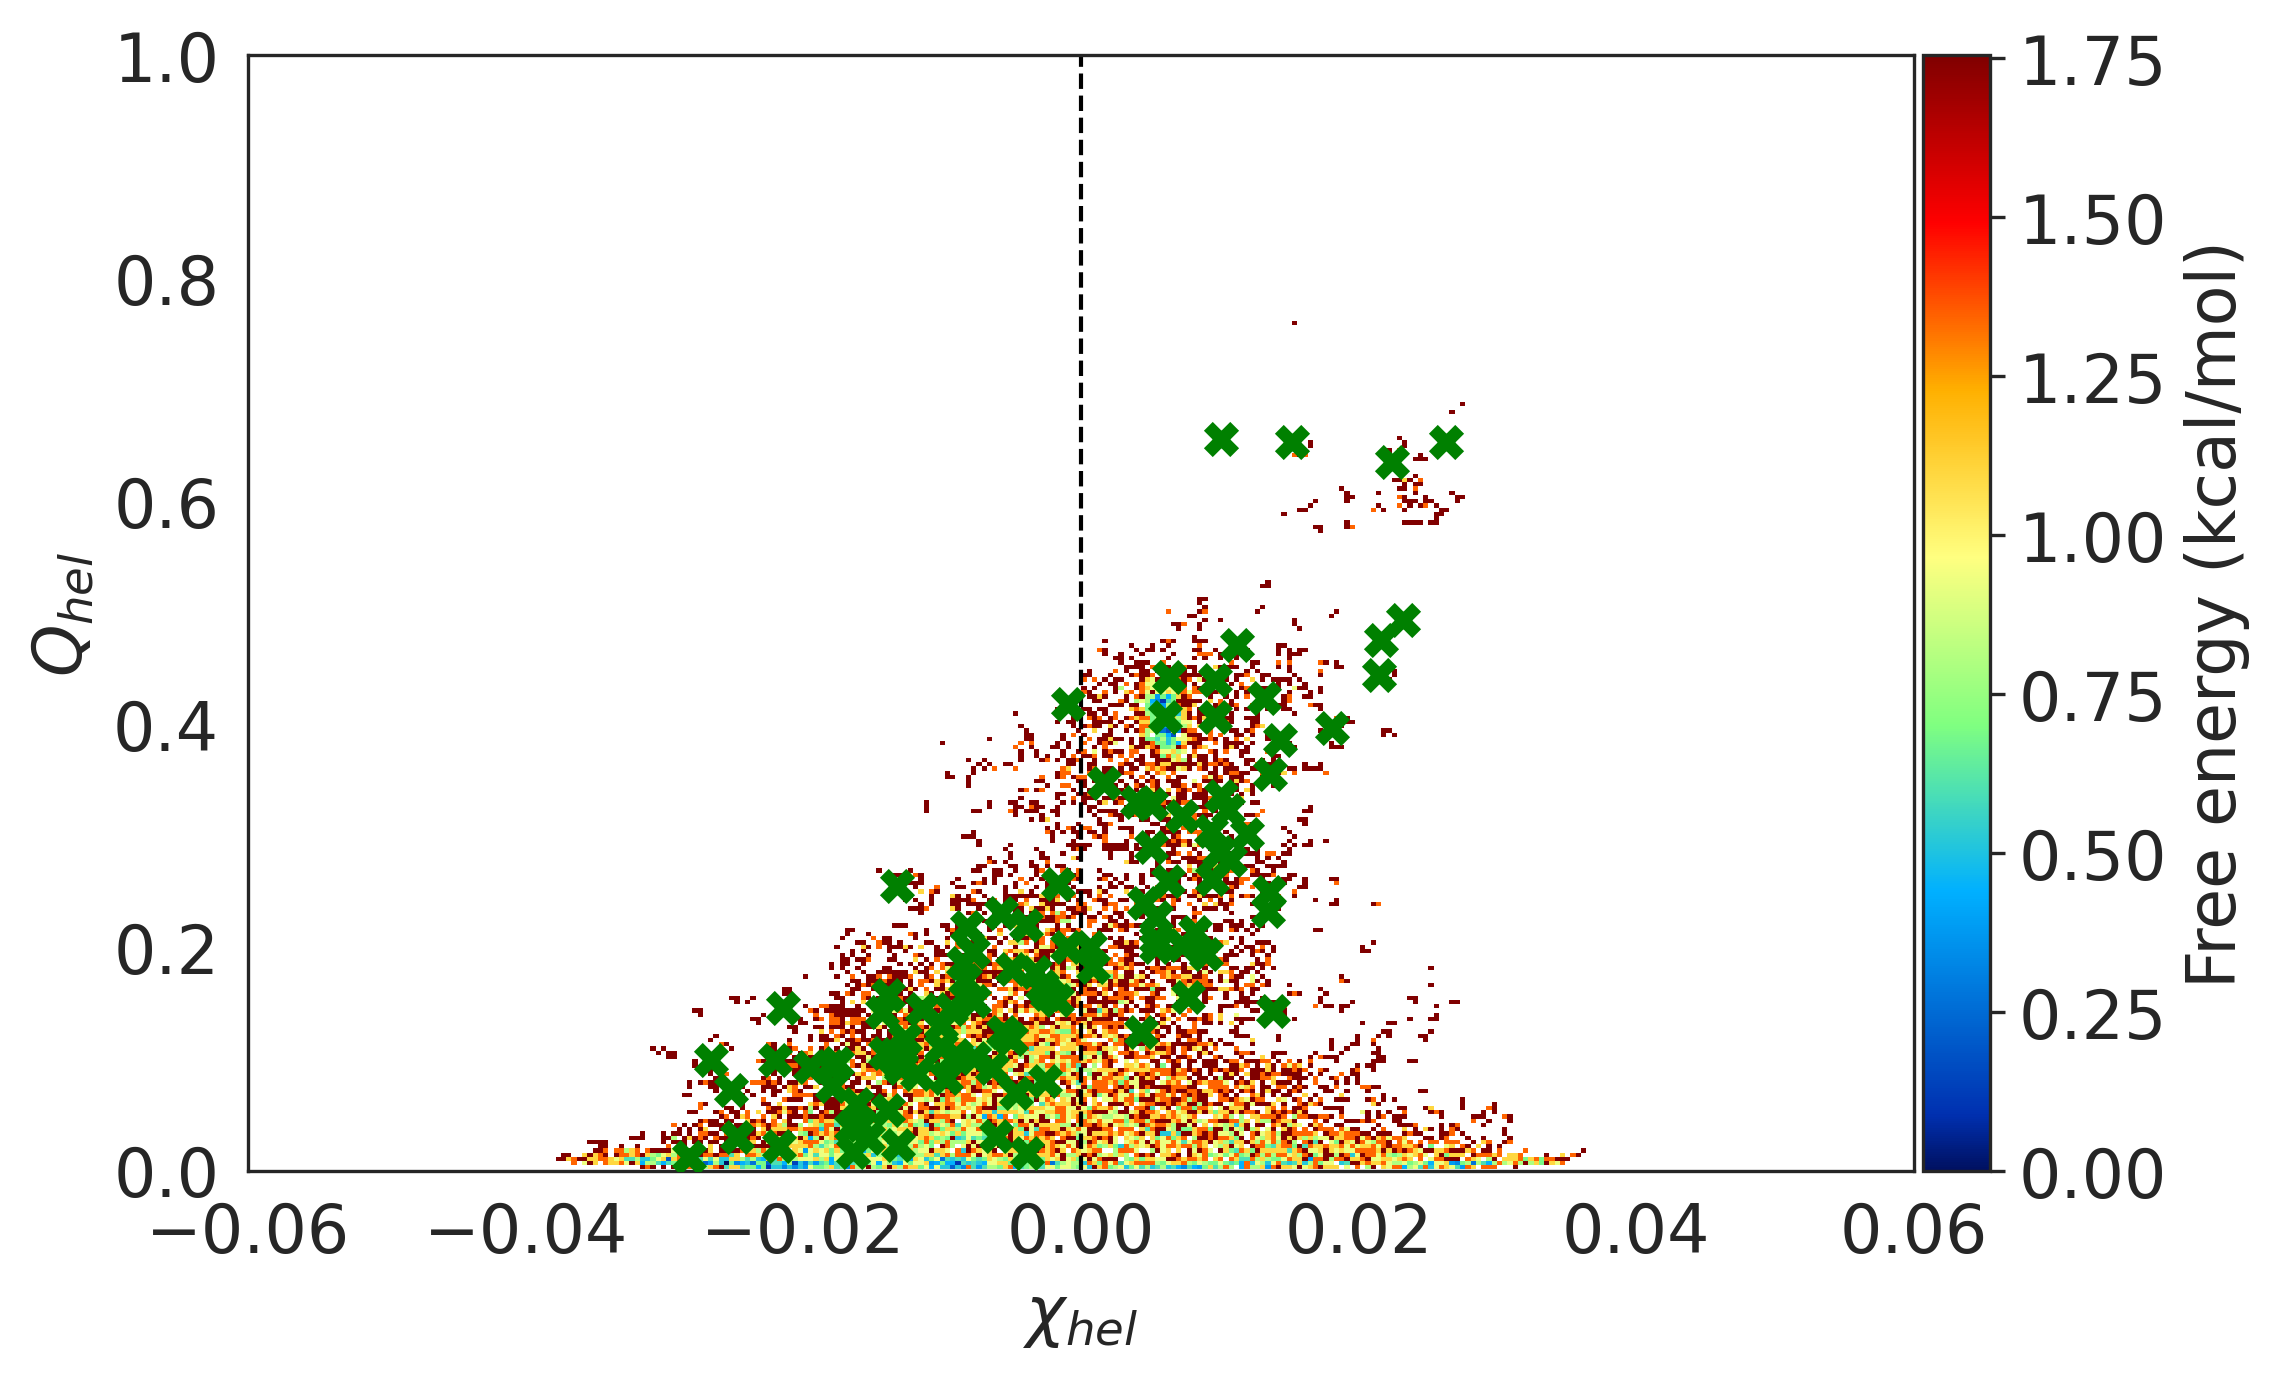

In [9]:
p = 'Ala15/Ala15_map=CA-Map4/simulation_NVT/traj_mol=ala15_dt=2_teq=0_t=5000_nmol=1_nchains=100_mode=helix_seed=22/trajectory.pkl'

traj_ = pkl.load(open(p,'rb'))
print('Loaded trajectory shape:', traj_.shape)
starting_frames = [10000*i for i in range(100)]

CA_indices = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
CA_pairs = [(i, i + 1) for i in range(len(CA_indices) - 1)]
traj_CA = traj_[:,CA_indices,:]
traj_starting_frames = traj_CA[starting_frames,:,:]


traj_CA = utils.split_into_chains(traj_CA, line_locs)
traj_CA, mask = ala15_CA_distance_filter(traj_CA, CA_pairs)

# merge chains 
traj_CA_merged = traj_CA.reshape(-1, traj_CA.shape[2], traj_CA.shape[3])
print('Merged traj shape after filtering:', traj_CA_merged.shape)

max_idx, min_idx, min_sum_idx, rg_values_CAMap4, helicity_values_CAMap4, xi_norm_ref_CAMap4 = plot_helicity_gyration(traj_CA_merged,Ala15_Dataset.displacement_fn_U, traj_starting_frames)

### coreMap2

Input shape: (100, 10000, 15, 3)
>> Processed shape: (100, 10000, 15, 3)
>> Valid frames per chain ns 4821.3 ± 697.8
Merged traj shape after filtering: (1000000, 15, 3)
Input coords shape: (1000000, 15, 3)
Valid coords shape: (964256, 15, 3), Number of valid frames: 964256
Frame with max helicity: 227162, value: 0.755501925945282
Frame with min helicity: 10008, value: 0.0001762365864124149
Frame with max Rg: 10005, value: 2.409234046936035
Frame with min Rg: 550012, value: 0.5183839797973633
Frame with lowest rg + helicity: 451090, value: 0.6759899854660034 (Rg: 0.5903750658035278, Helicity: 0.08561494201421738)


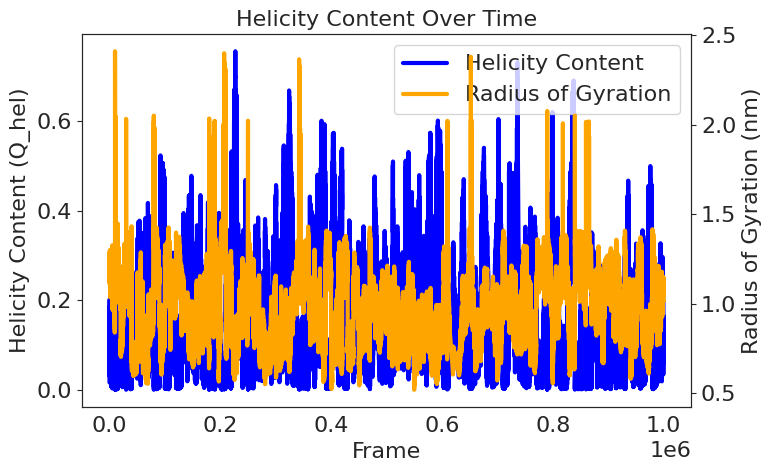

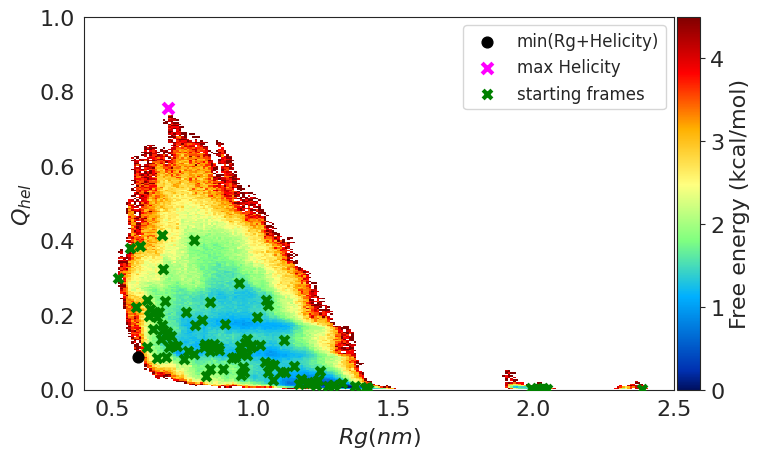

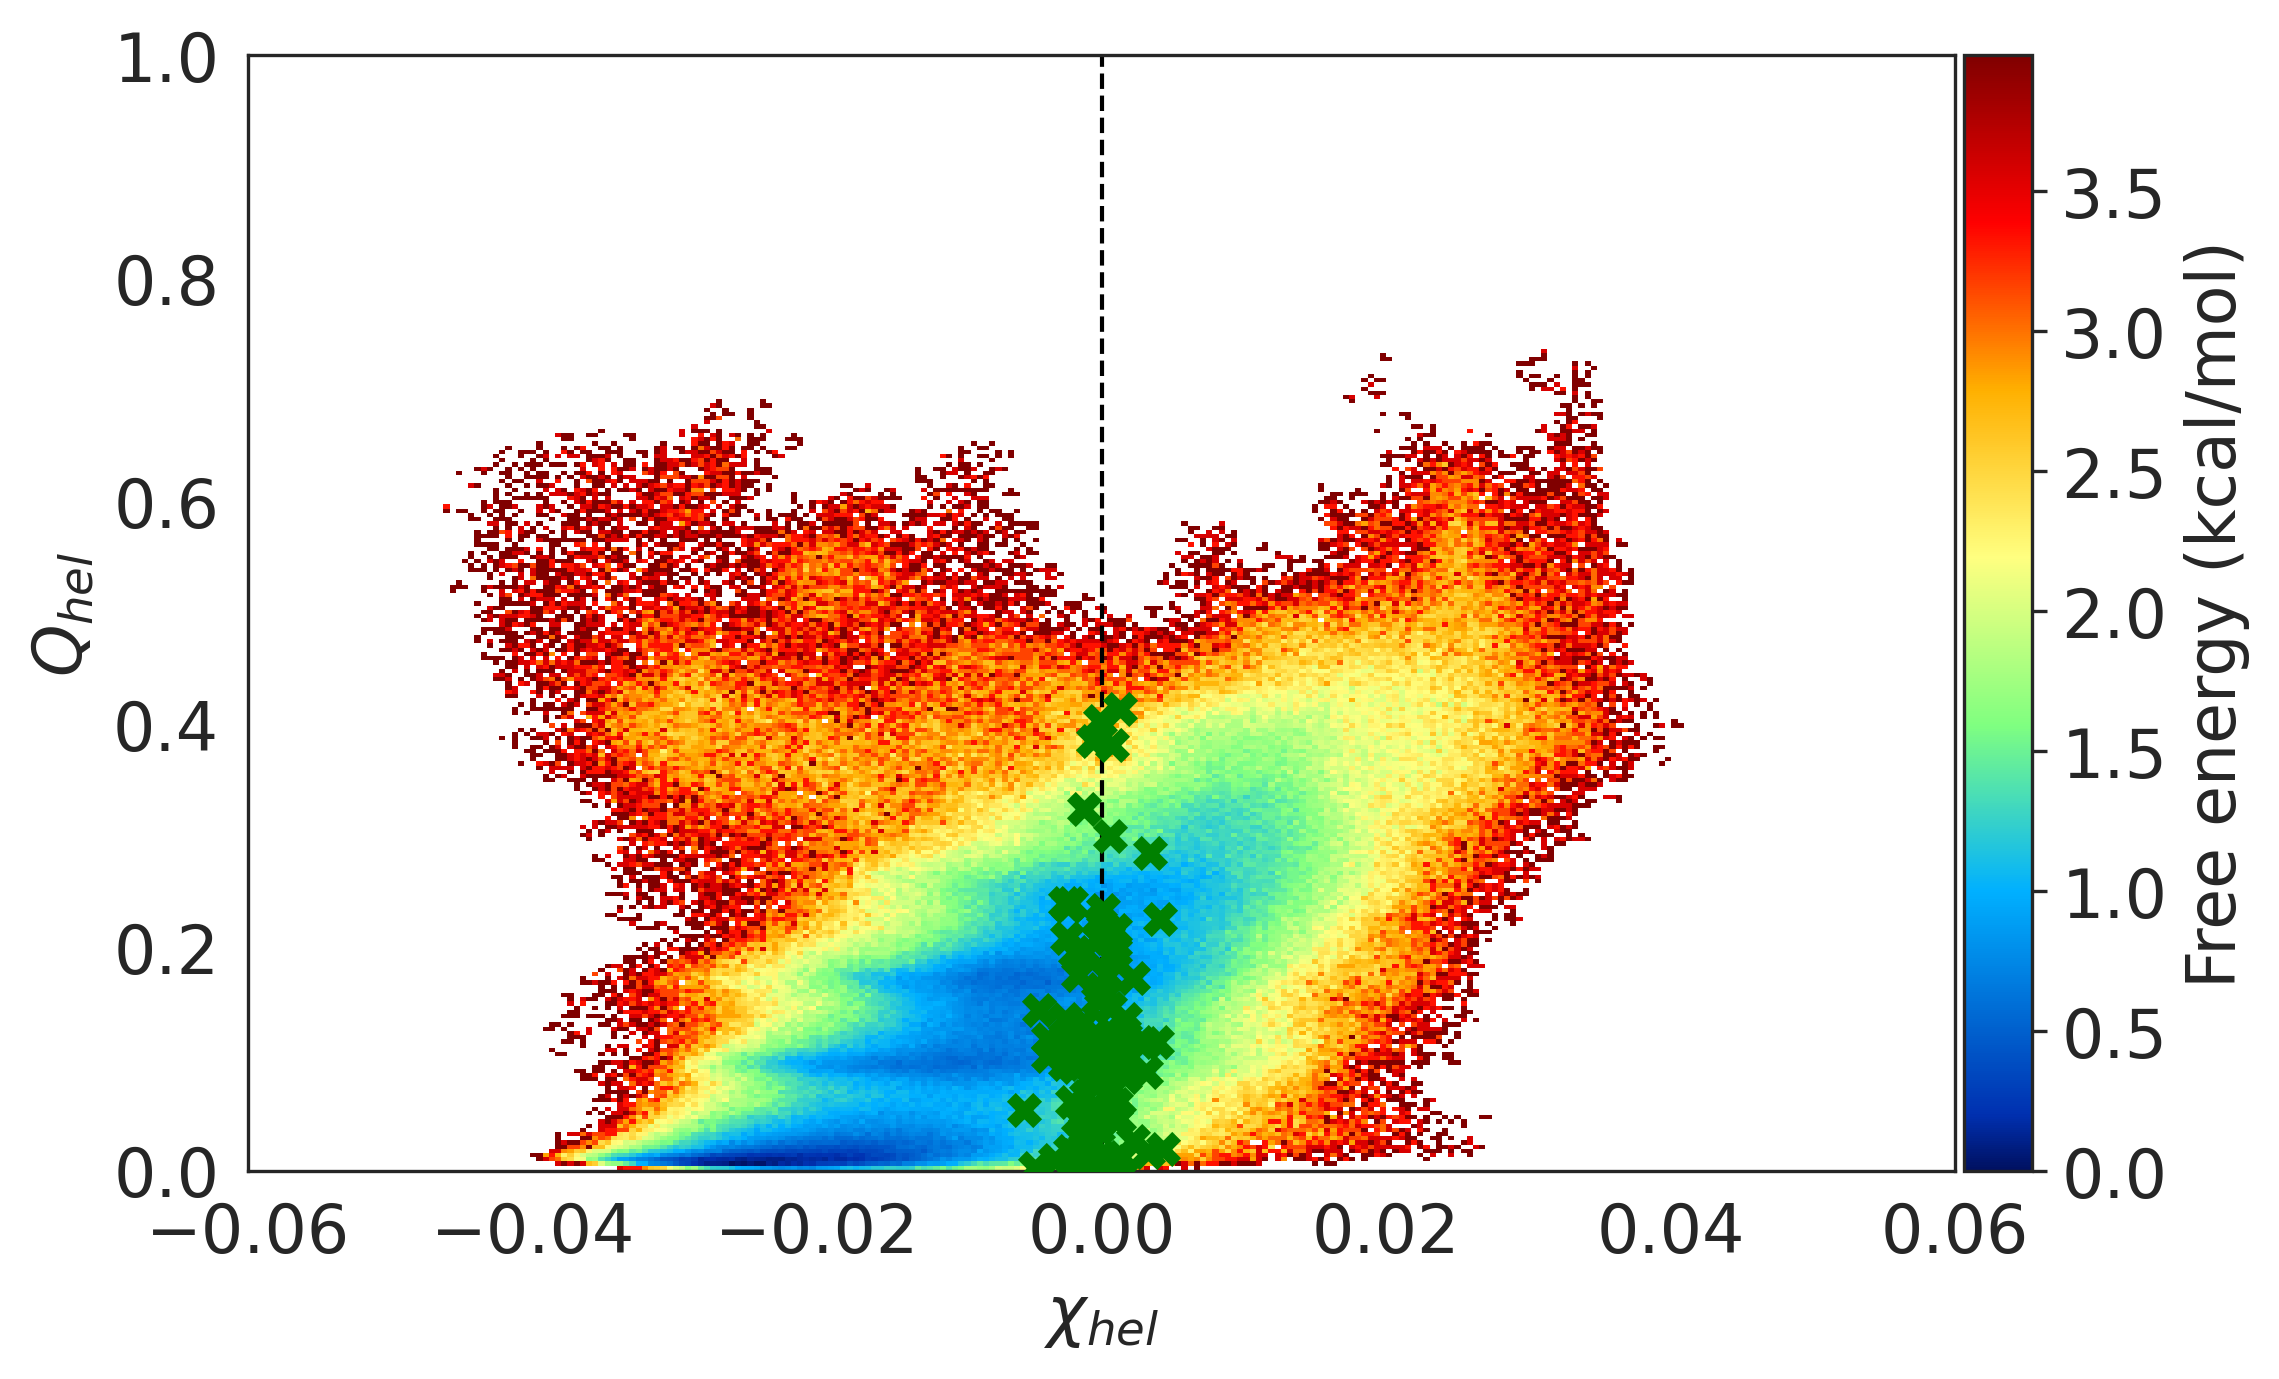

In [10]:
traj_path = '/home/franz/CG-Mapping-Benchmark/Ala15/Ala15_map=coreMap2/simulation_NVT/traj_mol=ala15_dt=2_teq=0_t=5000_nmol=1_nchains=100_mode=helix/trajectory.pkl'

traj_ = pkl.load(open(traj_path, 'rb'))

starting_frames = [10000*i for i in range(100)]
CA_indices = [2,5,8,11,14,17,20,23,26,29,32,35,38,41,44]
traj_CA = traj_[:,CA_indices,:]
traj_starting_frames = traj_CA[starting_frames,:,:]
CA_pairs = [(i, i + 1) for i in range(len(CA_indices) - 1)]

traj_CA = utils.split_into_chains(traj_CA, line_locs)
traj_CA, mask = ala15_CA_distance_filter(traj_CA, CA_pairs)
traj_CA_merged = traj_CA.reshape(-1, traj_CA.shape[2], traj_CA.shape[3])
print('Merged traj shape after filtering:', traj_CA_merged.shape)

max_idx, min_idx, min_sum_idx, rg_values_coreMap2, helicity_values_coreMap2, xi_norm_ref_coreMap2 = plot_helicity_gyration(traj_CA_merged, Ala15_Dataset.displacement_fn_U, traj_starting_frames)

### coreBetaMap2

Input shape: (100, 10000, 15, 3)
>> Processed shape: (100, 10000, 15, 3)
>> Valid frames per chain ns 3763.5 ± 1674.4
Merged traj shape after filtering: (1000000, 15, 3)
Input coords shape: (1000000, 15, 3)
Valid coords shape: (752702, 15, 3), Number of valid frames: 752702
Frame with max helicity: 256612, value: 0.8572462797164917
Frame with min helicity: 393233, value: 0.001045362325385213
Frame with max Rg: 392200, value: 2.3373401165008545
Frame with min Rg: 721017, value: 0.5122764110565186
Frame with lowest rg + helicity: 450094, value: 0.6887686252593994 (Rg: 0.5900019407272339, Helicity: 0.09876669943332672)


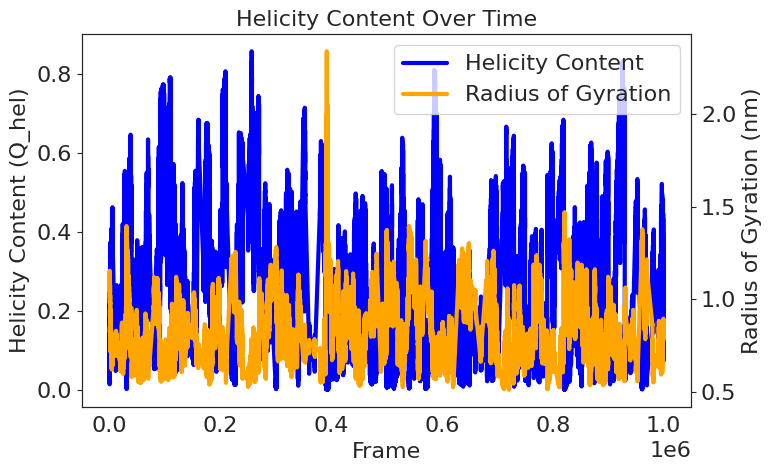

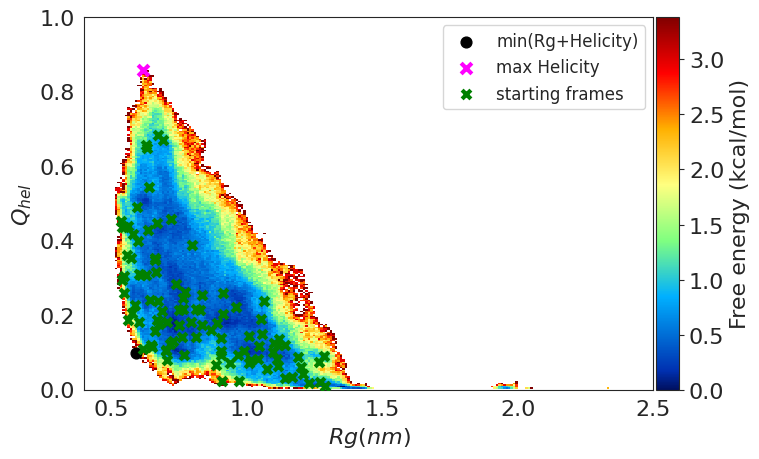

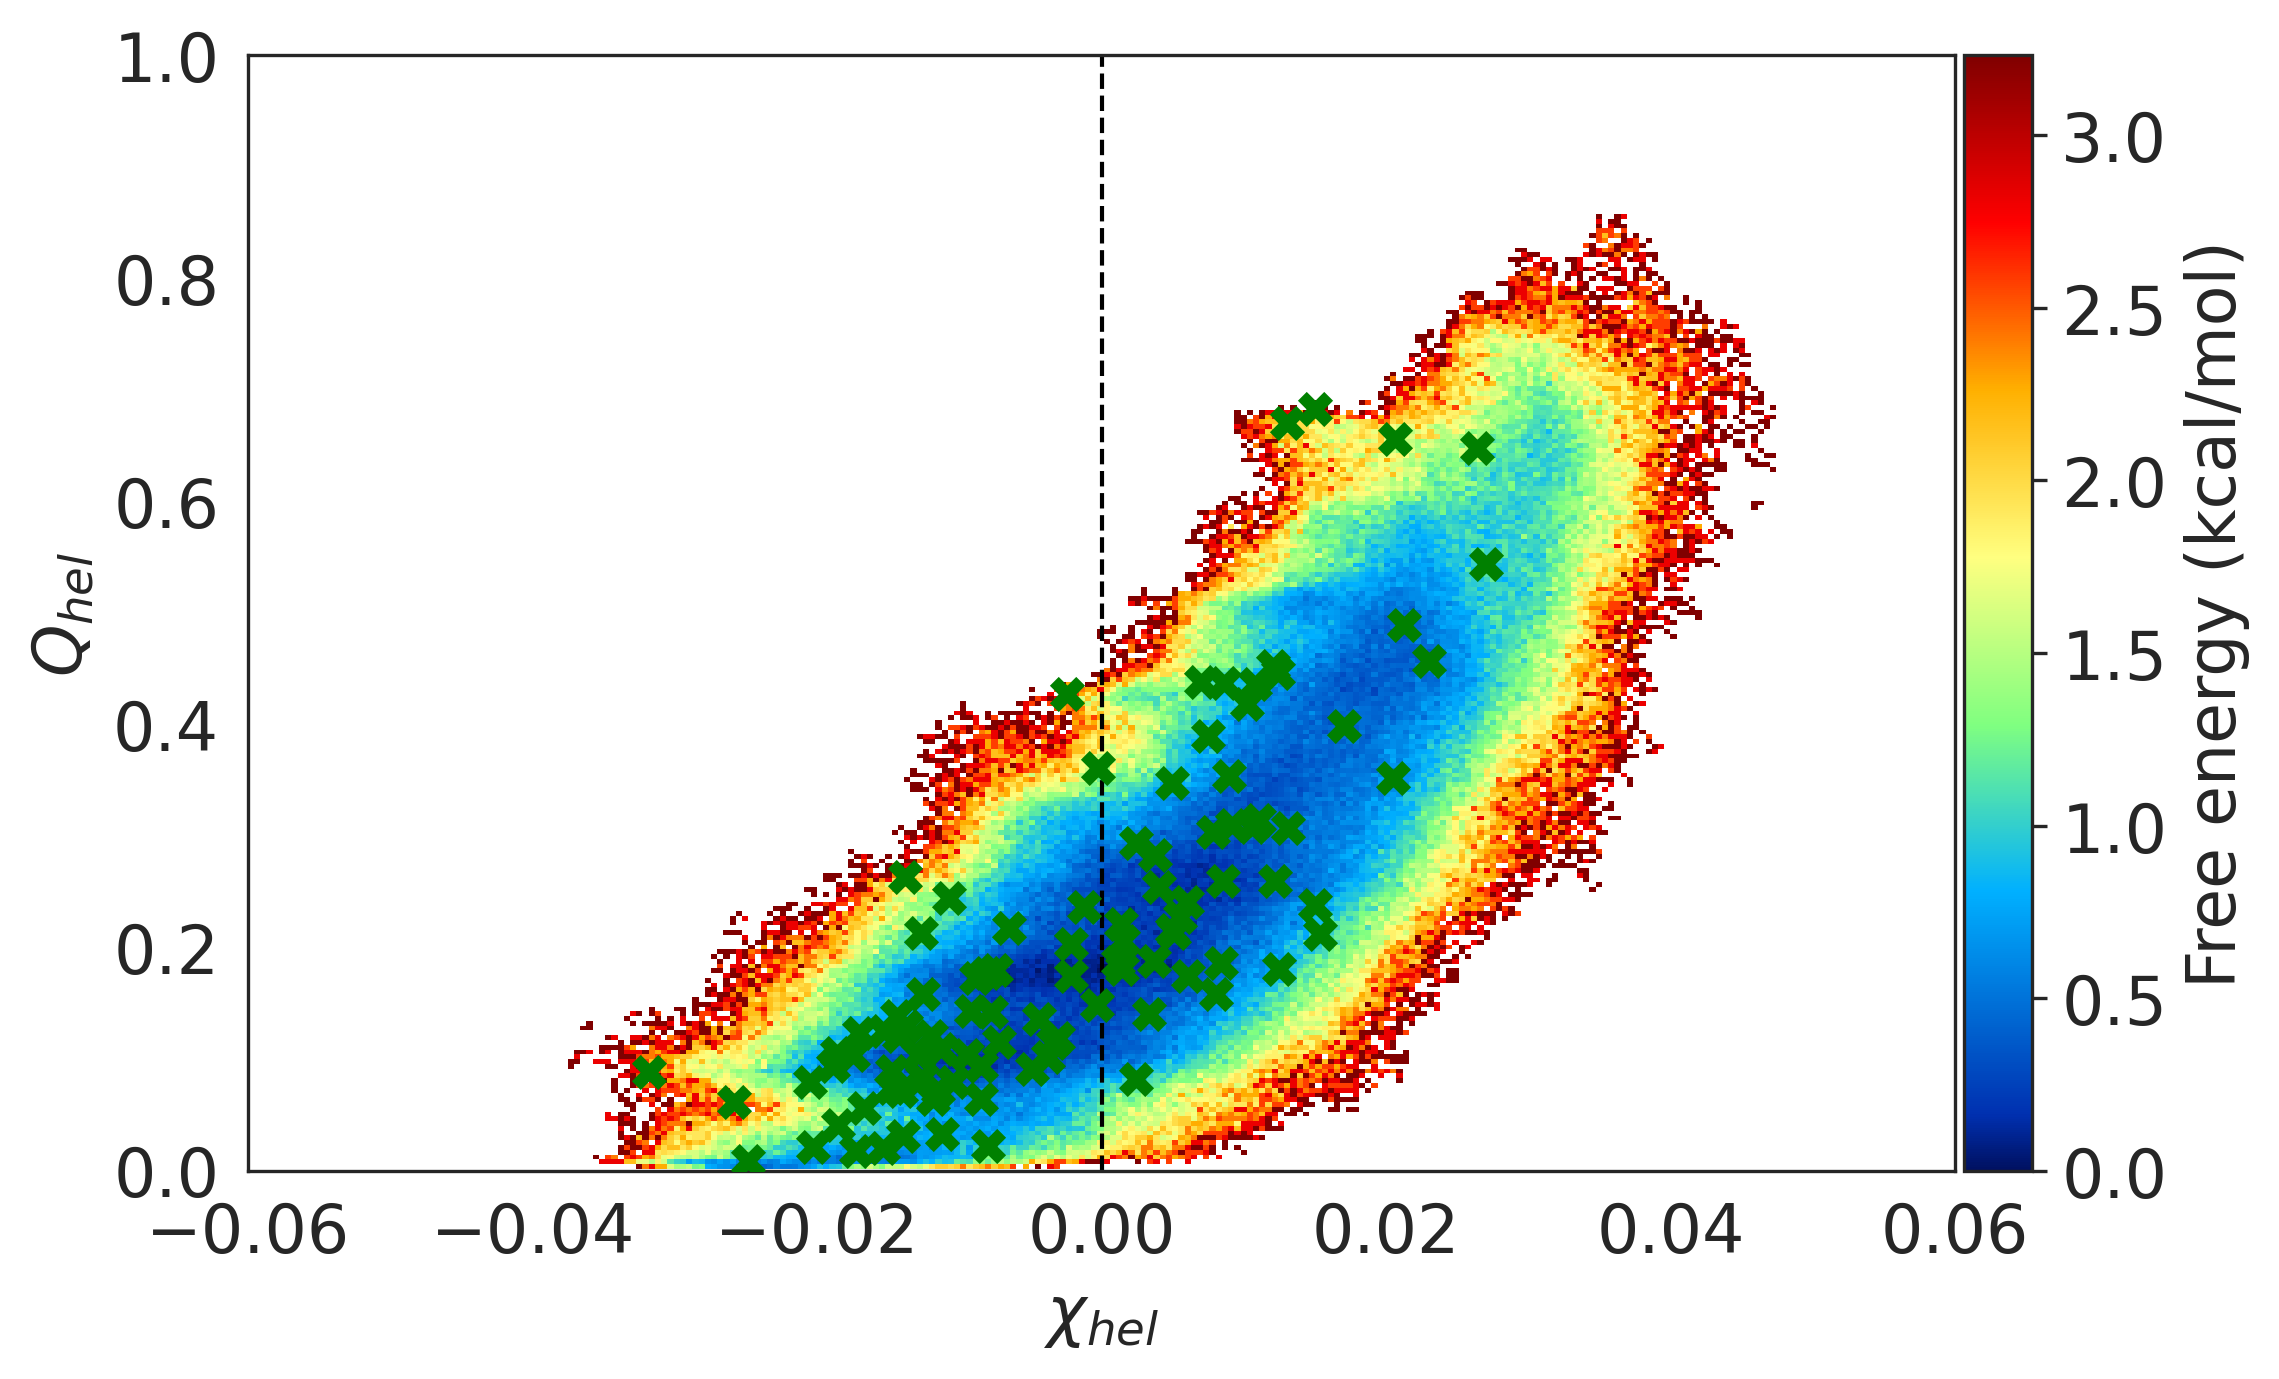

In [11]:
traj_path = '/home/franz/CG-Mapping-Benchmark/Ala15/Ala15_map=coreBetaMap2/simulation_NVT/traj_mol=ala15_dt=2_teq=0_t=5000_nmol=1_nchains=100_mode=helix/trajectory.pkl'

traj_ = pkl.load(open(traj_path, 'rb'))
starting_frames = [10000*i for i in range(100)]

CA_indices_coreBetaMap2 = [2,6,10,14,18,22,26,30,34,38,42,46,50,54,58]
traj_CA = traj_[:,CA_indices_coreBetaMap2,:]
traj_starting_frames = traj_CA[starting_frames,:,:]
CA_pairs = [(i, i + 1) for i in range(len(CA_indices_coreBetaMap2) - 1)]

traj_CA = utils.split_into_chains(traj_CA, line_locs)
traj_CA, mask = ala15_CA_distance_filter(traj_CA, CA_pairs)
traj_CA_merged = traj_CA.reshape(-1, traj_CA.shape[2], traj_CA.shape[3])
print('Merged traj shape after filtering:', traj_CA_merged.shape)

max_idx, min_idx, min_sum_idx, rg_values_coreBetaMap2, helicity_values_coreBetaMap2, xi_norm_ref_coreBetaMap2 = plot_helicity_gyration(traj_CA_merged, Ala15_Dataset.displacement_fn_U, traj_starting_frames)

### Reference

Input coords shape: (500001, 15, 3)
Valid coords shape: (500001, 15, 3), Number of valid frames: 500001
Frame with max helicity: 119958, value: 0.846214234828949
Frame with min helicity: 0, value: 0.000152556283865124
Frame with max Rg: 0, value: 2.388699769973755
Frame with min Rg: 382351, value: 0.5062853693962097
Frame with lowest rg + helicity: 10896, value: 0.6617346405982971 (Rg: 0.5819931626319885, Helicity: 0.07974148541688919)


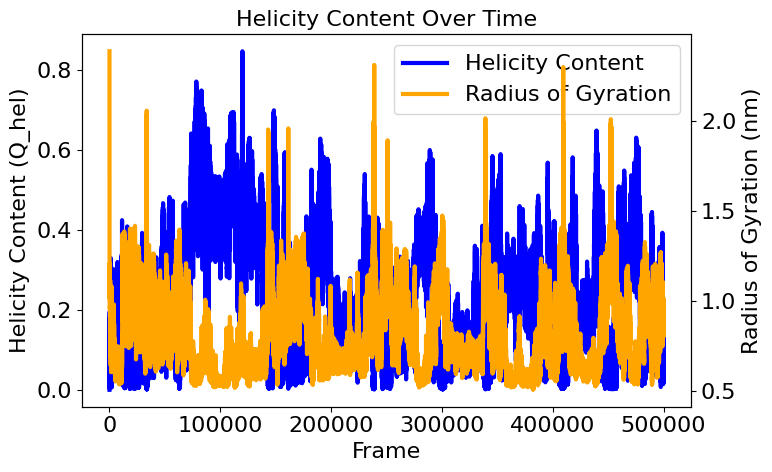

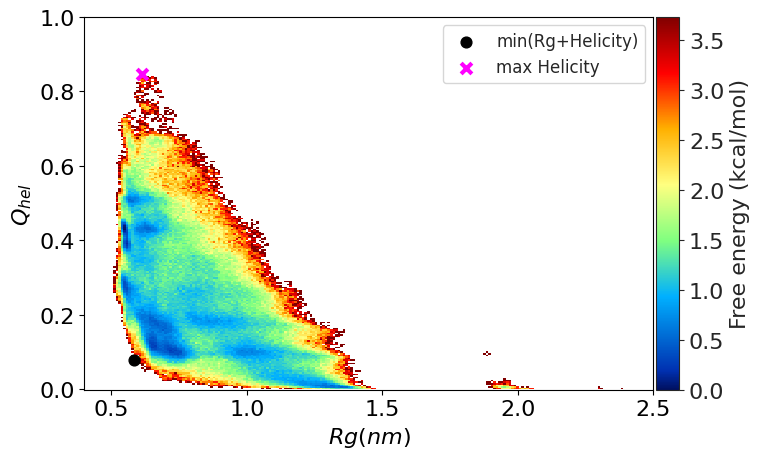

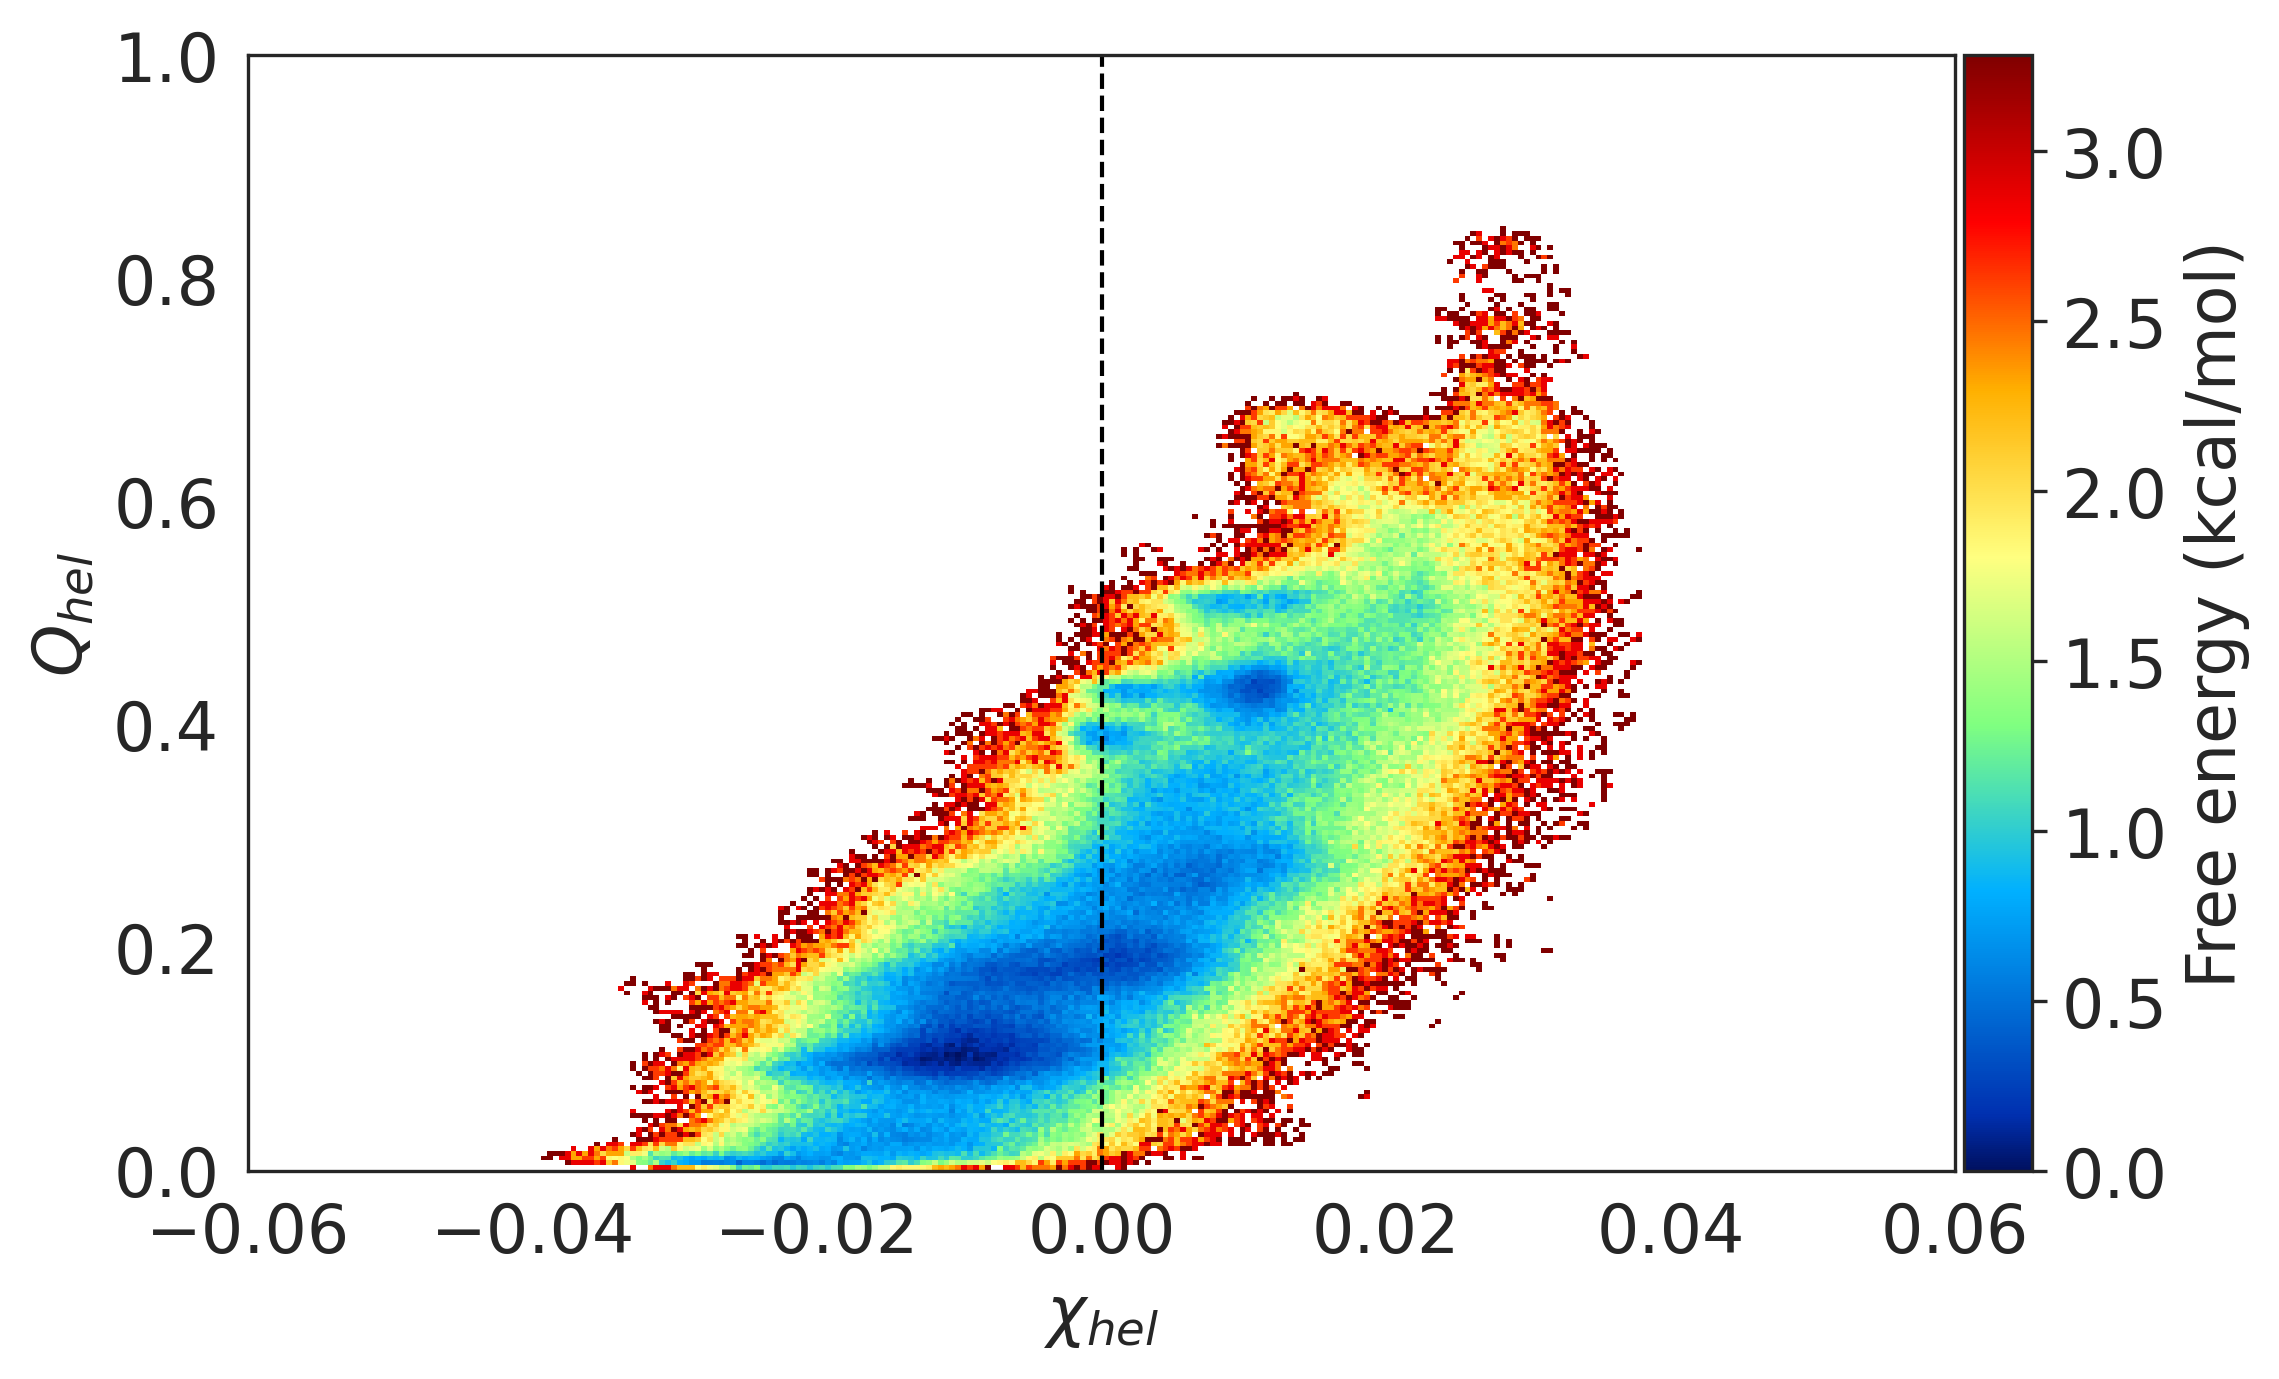

In [4]:
max_idx, min_idx, min_sum_idx, rg_values_ref, helicity_values_ref, xi_norm_ref = plot_helicity_gyration(Ref_coords_CA_500ns,Ala15_Dataset.displacement_fn_X, save_pdf=True, prefix='Ala15/', suffix='_reference=500ns')

### Generate starting indices

In [ ]:
# elementwise_product = xi_norm_ref_np.flatten() * helicity_values_np

# # Get the indices of the lowest 10 entries in elementwise_product
# lowest_indices = np.argsort(np.abs(elementwise_product))[:100]

# # Print the frames and their corresponding values
# for idx in lowest_indices:
#     print(f"Frame: {idx}, Value: {elementwise_product[idx]}")

### VIS

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100  # 200 e.g. is really fine, but slower

tick_font_size = 16
axis_label_font_size = 16
legend_font_size = 16
line_width = 3

xlim=(-0.06, 0.06)
ylim=(-0.001, 1.0)
bins = 200

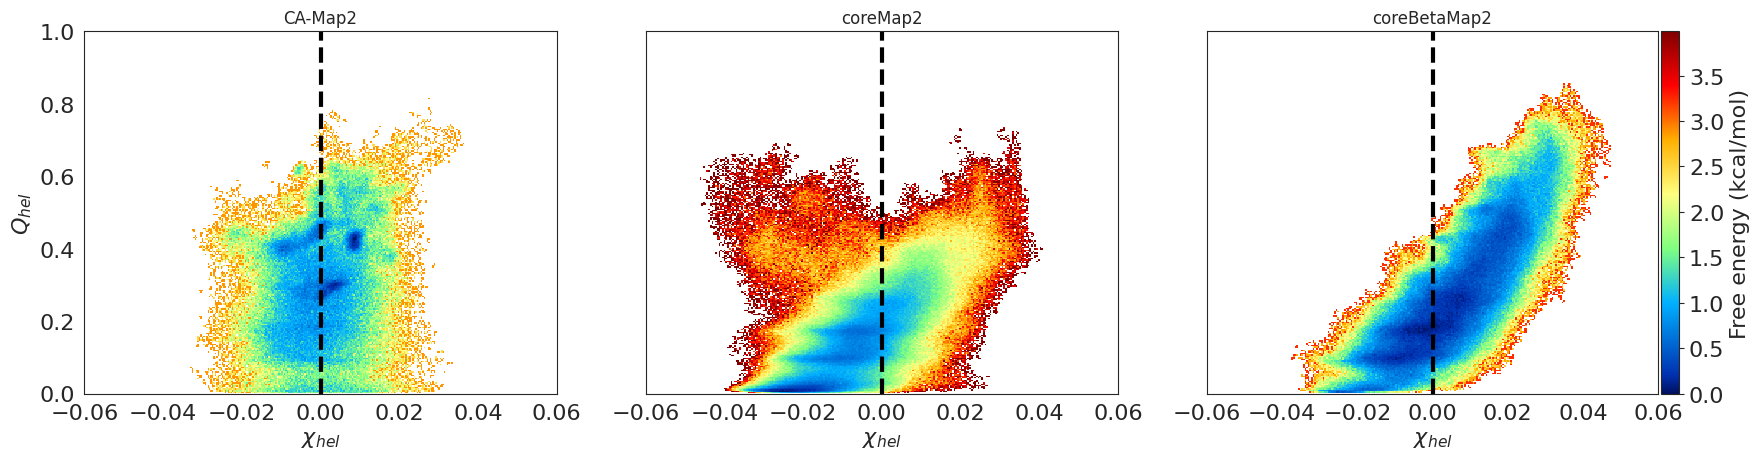

In [ ]:
chi_vals = [xi_norm_ref_CAMap2, xi_norm_ref_coreMap2, xi_norm_ref_coreBetaMap2]
helicity_vals = [helicity_values_CAMap2, helicity_values_coreMap2, helicity_values_coreBetaMap2]

fig, axes = plt.subplots(1,3, figsize=(18, 5))
scale_used = utils.determine_free_energy_scale(chi_vals, helicity_vals, 300. * quantity.kb, bins=bins)

# Plot for CA-Map2
utils.plot_histogram_free_energy(
    axes[0], xi_norm_ref_CAMap2, helicity_values_CAMap2, 
    kbt=300. * quantity.kb,
    is_angular=False,
    xlabel="$\chi_{hel}$",
    ylabel_text="$Q_{hel}$",
    show_ylabel=True,
    ylim=ylim,
    xlim=xlim,
    scale=scale_used,
    show_yticks=True,
    bins=bins,
)
axes[0].axvline(0, color='k', linestyle='--', linewidth=1)
axes[0].set_title("CA-Map2", fontsize=12)

# Plot for coreMap2
utils.plot_histogram_free_energy(
    axes[1], xi_norm_ref_coreMap2, helicity_values_coreMap2, 
    kbt=300. * quantity.kb,
    is_angular=False,
    xlabel="$\chi_{hel}$",
    ylabel_text="$Q_{hel}$",
    show_ylabel=False,
    ylim=ylim,
    xlim=xlim,
    scale=scale_used,
    show_yticks=False,
    bins=bins,
)
axes[1].axvline(0, color='k', linestyle='--', linewidth=1)
axes[1].set_title("coreMap2", fontsize=12)

# Plot for coreBetaMap2
utils.plot_histogram_free_energy(
    axes[2], xi_norm_ref_coreBetaMap2, helicity_values_coreBetaMap2, 
    kbt=300. * quantity.kb,
    is_angular=False,
    xlabel="$\chi_{hel}$",
    ylabel_text="$Q_{hel}$",
    show_ylabel=False,
    ylim=ylim,
    xlim=xlim,
    scale=scale_used,
    show_yticks=False,
    bins=bins,
    legend=True
)
axes[2].axvline(0, color='k', linestyle='--', linewidth=1)
axes[2].set_title("coreBetaMap2", fontsize=12)

# set font sizes
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=tick_font_size)
    ax.xaxis.label.set_size(axis_label_font_size)
    ax.yaxis.label.set_size(axis_label_font_size)
    for line in ax.get_lines():
        line.set_linewidth(line_width)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.savefig(f'Ala15/helicity_vs_xi_CAMap2-coreMap2-coreBetaMap2.pdf')

plt.show()

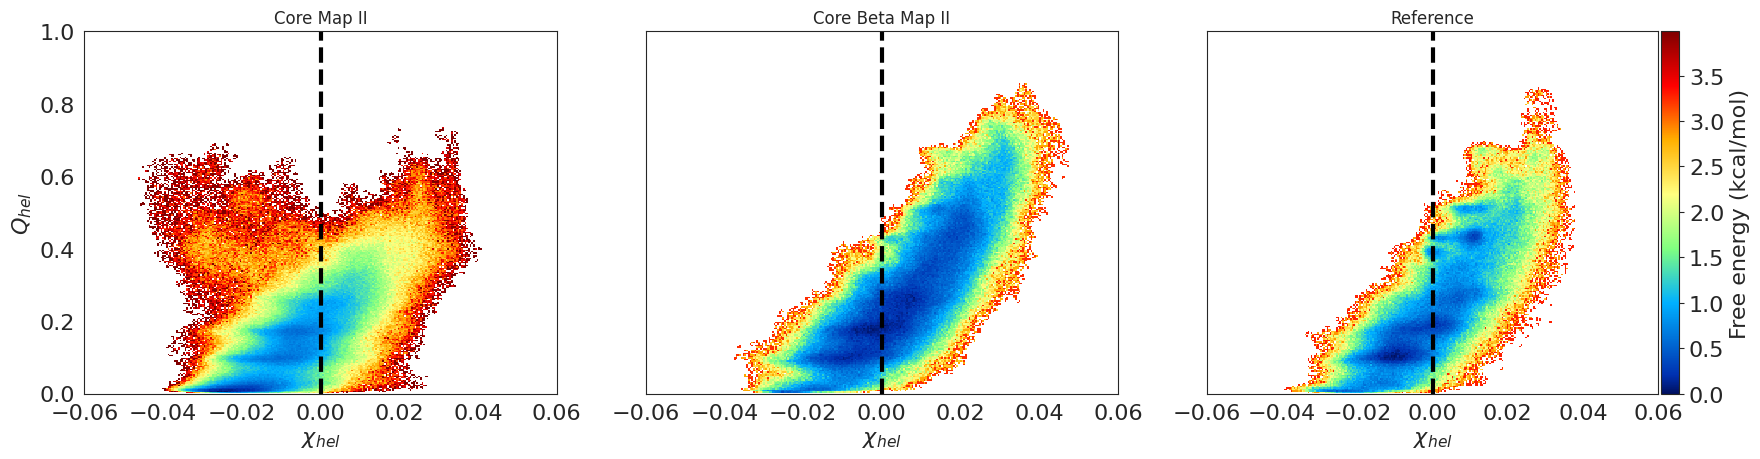

In [ ]:
chi_vals = [xi_norm_ref, xi_norm_ref_coreMap2, xi_norm_ref_coreBetaMap2]
helicity_vals = [helicity_values_ref, helicity_values_coreMap2, helicity_values_coreBetaMap2]

fig, axes = plt.subplots(1,3, figsize=(18, 5))

scale_used = utils.determine_free_energy_scale(chi_vals, helicity_vals, 300. * quantity.kb, bins=bins)

# Plot for CA-Map2
utils.plot_histogram_free_energy(
    axes[2], xi_norm_ref, helicity_values_ref, 
    kbt=300. * quantity.kb,
    is_angular=False,
    xlabel="$\chi_{hel}$",
    ylabel_text="$Q_{hel}$",
    ylim=ylim,
    xlim=xlim,
    show_yticks=False,
    scale=scale_used,
    legend=True,
    bins=bins,
)
axes[2].axvline(0, color='k', linestyle='--', linewidth=1)
axes[2].set_title("Reference", fontsize=12)

# Plot for coreMap2
utils.plot_histogram_free_energy(
    axes[0], xi_norm_ref_coreMap2, helicity_values_coreMap2, 
    kbt=300. * quantity.kb,
    is_angular=False,
    xlabel="$\chi_{hel}$",
    ylabel_text="$Q_{hel}$",
    ylim=ylim,
    xlim=xlim,
    scale=scale_used,
    show_ylabel=True,
    show_yticks=True,
    bins=bins,
)
axes[0].axvline(0, color='k', linestyle='--', linewidth=1)
axes[0].set_title("Core Map II", fontsize=12)

# Plot for coreBetaMap2
utils.plot_histogram_free_energy(
    axes[1], xi_norm_ref_coreBetaMap2, helicity_values_coreBetaMap2, 
    kbt=300. * quantity.kb,
    is_angular=False,
    xlabel="$\chi_{hel}$",
    ylabel_text="$Q_{hel}$",
    show_ylabel=False,
    ylim=ylim,
    xlim=xlim,
    scale=scale_used,
    show_yticks=False,
    bins=bins,
)
axes[1].axvline(0, color='k', linestyle='--', linewidth=1)
axes[1].set_title("Core Beta Map II", fontsize=12)

# set font sizes
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=tick_font_size)
    ax.xaxis.label.set_size(axis_label_font_size)
    ax.yaxis.label.set_size(axis_label_font_size)
    for line in ax.get_lines():
        line.set_linewidth(line_width)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.savefig(f'Ala15/helicity_vs_xi_coreMap2-coreBetaMap2-ref.pdf')

plt.show()

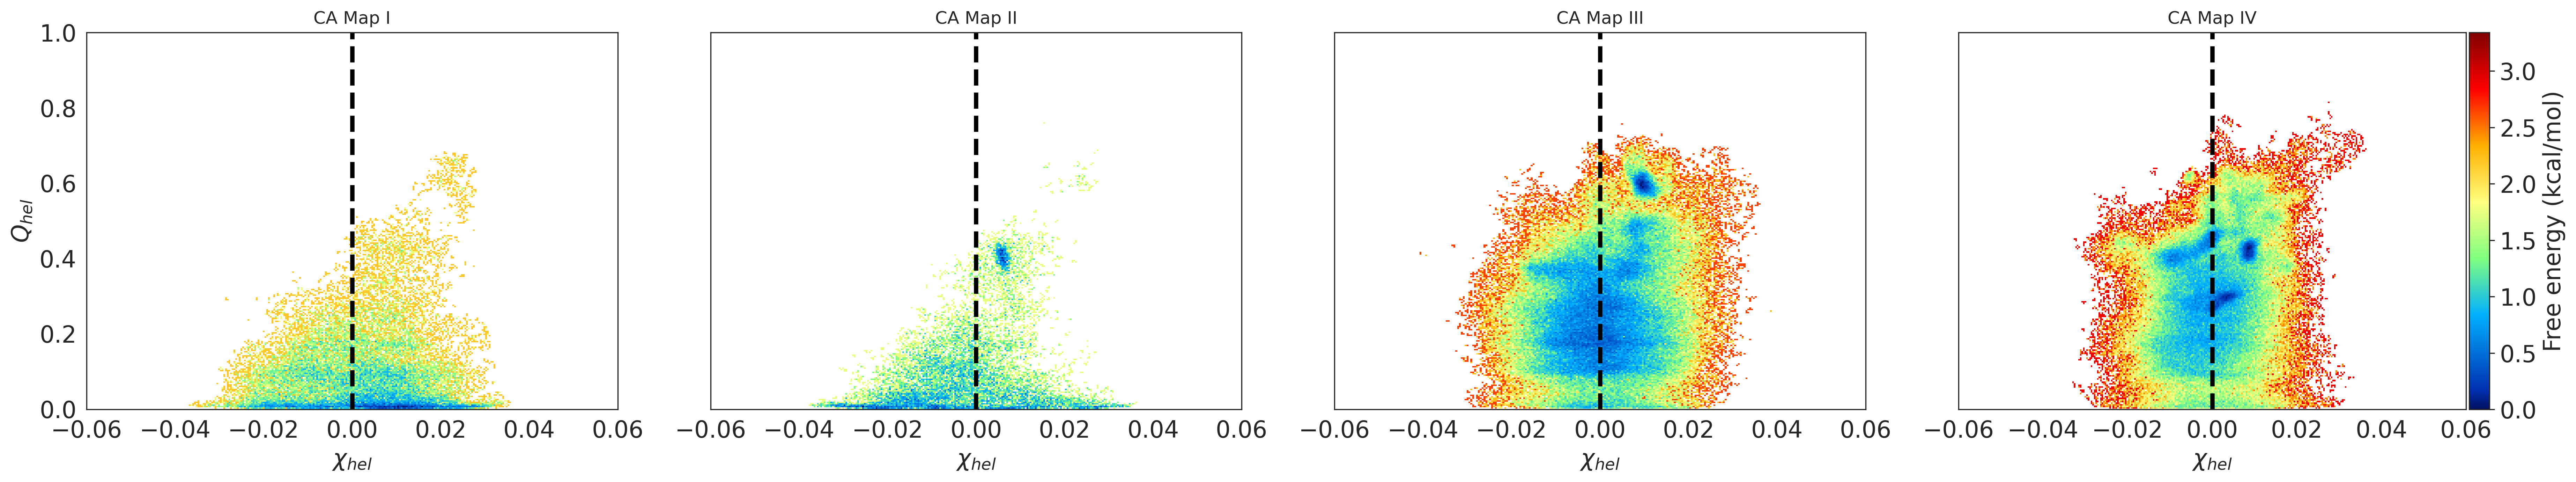

In [17]:
chi_vals = [xi_norm_ref_CAMap1, xi_norm_ref_CAMap2, xi_norm_ref_CAMap3, xi_norm_ref_CAMap4]
helicity_vals = [helicity_values_CAMap1, helicity_values_CAMap2, helicity_values_CAMap3, helicity_values_CAMap4]


fig, axes = plt.subplots(1,4, figsize=(25, 5))

scale_used = utils.determine_free_energy_scale(chi_vals, helicity_vals, 300. * quantity.kb, bins=bins)


# Plot for CA-Map2
utils.plot_histogram_free_energy(
    axes[0], xi_norm_ref_CAMap1, helicity_values_CAMap1, 
    kbt=300. * quantity.kb,
    is_angular=False,
    xlabel="$\chi_{hel}$",
    ylabel_text="$Q_{hel}$",
    show_ylabel=True,
    ylim=ylim,
    xlim=xlim,
    scale=scale_used,
    show_yticks=True,
    bins=bins,
)
axes[0].axvline(0, color='k', linestyle='--', linewidth=1)
axes[0].set_title("CA Map I", fontsize=12)

# Plot for coreMap2
utils.plot_histogram_free_energy(
    axes[1], xi_norm_ref_CAMap4, helicity_values_CAMap4, 
    kbt=300. * quantity.kb,
    is_angular=False,
    xlabel="$\chi_{hel}$",
    ylabel_text="$Q_{hel}$",
    show_ylabel=False,
    ylim=ylim,
    xlim=xlim,
    scale=scale_used,
    show_yticks=False,
    bins=bins,
)
axes[1].axvline(0, color='k', linestyle='--', linewidth=1)
axes[1].set_title("CA Map II", fontsize=12)

# Plot for coreBetaMap2
utils.plot_histogram_free_energy(
    axes[2], xi_norm_ref_CAMap3, helicity_values_CAMap3, 
    kbt=300. * quantity.kb,
    is_angular=False,
    xlabel="$\chi_{hel}$",
    ylabel_text="$Q_{hel}$",
    show_ylabel=False,
    ylim=ylim,
    xlim=xlim,
    scale=scale_used,
    show_yticks=False,
    bins=bins,
    legend=False
)
axes[2].axvline(0, color='k', linestyle='--', linewidth=1)
axes[2].set_title("CA Map III", fontsize=12)

# Plot for coreBetaMap2
utils.plot_histogram_free_energy(
    axes[3], xi_norm_ref_CAMap2, helicity_values_CAMap2, 
    kbt=300. * quantity.kb,
    is_angular=False,
    xlabel="$\chi_{hel}$",
    ylabel_text="$Q_{hel}$",
    show_ylabel=False,
    ylim=ylim,
    xlim=xlim,
    scale=scale_used,
    show_yticks=False,
    bins=bins,
    legend=True
)
axes[3].axvline(0, color='k', linestyle='--', linewidth=1)
axes[3].set_title("CA Map IV", fontsize=12)


# set font sizes
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=tick_font_size)
    ax.xaxis.label.set_size(axis_label_font_size)
    ax.yaxis.label.set_size(axis_label_font_size)
    for line in ax.get_lines():
        line.set_linewidth(line_width)
        
plt.tight_layout()  # Adjust layout to prevent overlap
plt.savefig(f'Ala15/helicity_vs_xi_norm_MACE_CA_models.pdf')

plt.show()